### 1.	Purpose
#### Updating AI/ML model on the fly

##### This project aims to update a neural network AI/ML model on the fly using input data during its use stage, with a focus on image recognition.

The typical way to define a model is to first apply training and test data to create multiple possible models. Then, the models are evaluated based on metrics like accuracy, loss, and load, etc. Finally, the model with the best set of parameters is chosen. Once the model is finalized, it can be used in an application, however, there is no way to improve it after deployment.

The reason why we may want to improve the model after deployment is that data characteristics can change over time. For example, the shapes of numeral digits or vehicles may evolve gradually, which causes model deterioration. The challenge of adjusting the model during its use stage lies in determining how to obtain the correct labels for new data when the model cannot predict with 100% confidence.

One approach to address this is to consider all predictions from the current model as correct. This can be reasonable, especially when the model is well-trained and delivers over 90% accuracy. The model can be updated based on new data and predicted labels as a compromise.

One approach to address this issue is to consider all predictions from the current model as correct. This can be reasonable, especially when the model is well-trained and delivers over 90% accuracy. As a compromise, the model can be updated based on new data and the predicted labels.

Another method is to use time sequencing. For example, while we might not correctly predict a small, distant object at first, we may identify it as a car once it gets closer and the image becomes clearer. In this case, we can retroactively learn that the previous small object was also a car. This new data, with its presumably correct predicted label, can then be used for additional training.

For this project, to simplify the process, I will use handwritten digit data (0-9) instead of car images to improve the model in both scenarios: (i) shape changes over time and (ii) object size changes over short periods.

In [100]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import zoom

import tensorflow as tf
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

### 2.	Data Preparation

#### Preparing Training and Test Data

##### Download the numeral digit dataset and create new datasets that imitate older or distant object data.

This project uses the MNIST dataset for handwritten digit samples. The MNIST dataset includes 70,000 images in total, with 60,000 examples in the training set and 10,000 examples in the testing set. Both sets contain labeled images of 10 digits (0 to 9) in a 28x28 pixel grayscale format. Four new data types are created from the original dataset: the 1/2 size and 3/4 size datasets imitate older or more distant objects, while center-aligned and top-left-aligned data are used to explore whether recognition accuracy depends on the object's location.
 
- Original (Center, 28x28)	: Center-aligned, Original size (Original data)
- 21c (Center, 21x21)		: Center-aligned, 3/4 size (Old object data, Distant object data)
- 14c (Center, 14x14)		: Center-aligned, 1/2 size (Older object data, Farther distant object data)
- 21tl (Top Left, 21x21)		: Top-left corner aligned, 3/4 size (Old object data, Distant object data)  
- 14tl (Top Left, 14x14)		: Top-left corner aligned, 1/2 size (Older object data, Farther distant object data)



In [101]:
# Load the data from mnist for numerial numbers (0-9)
tf.random.set_seed(42)
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
# 60000 train data and 10000 test data

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


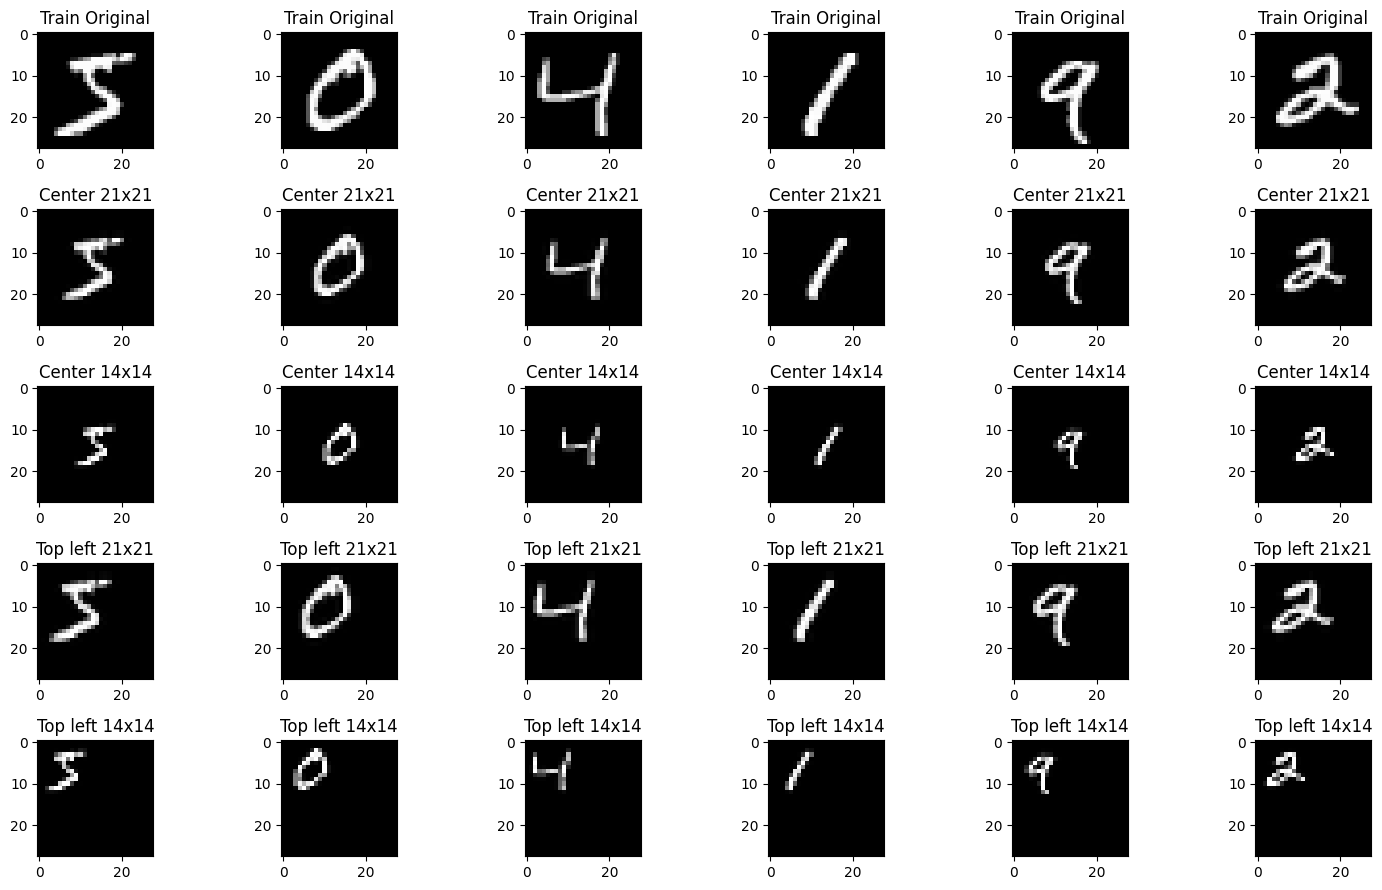

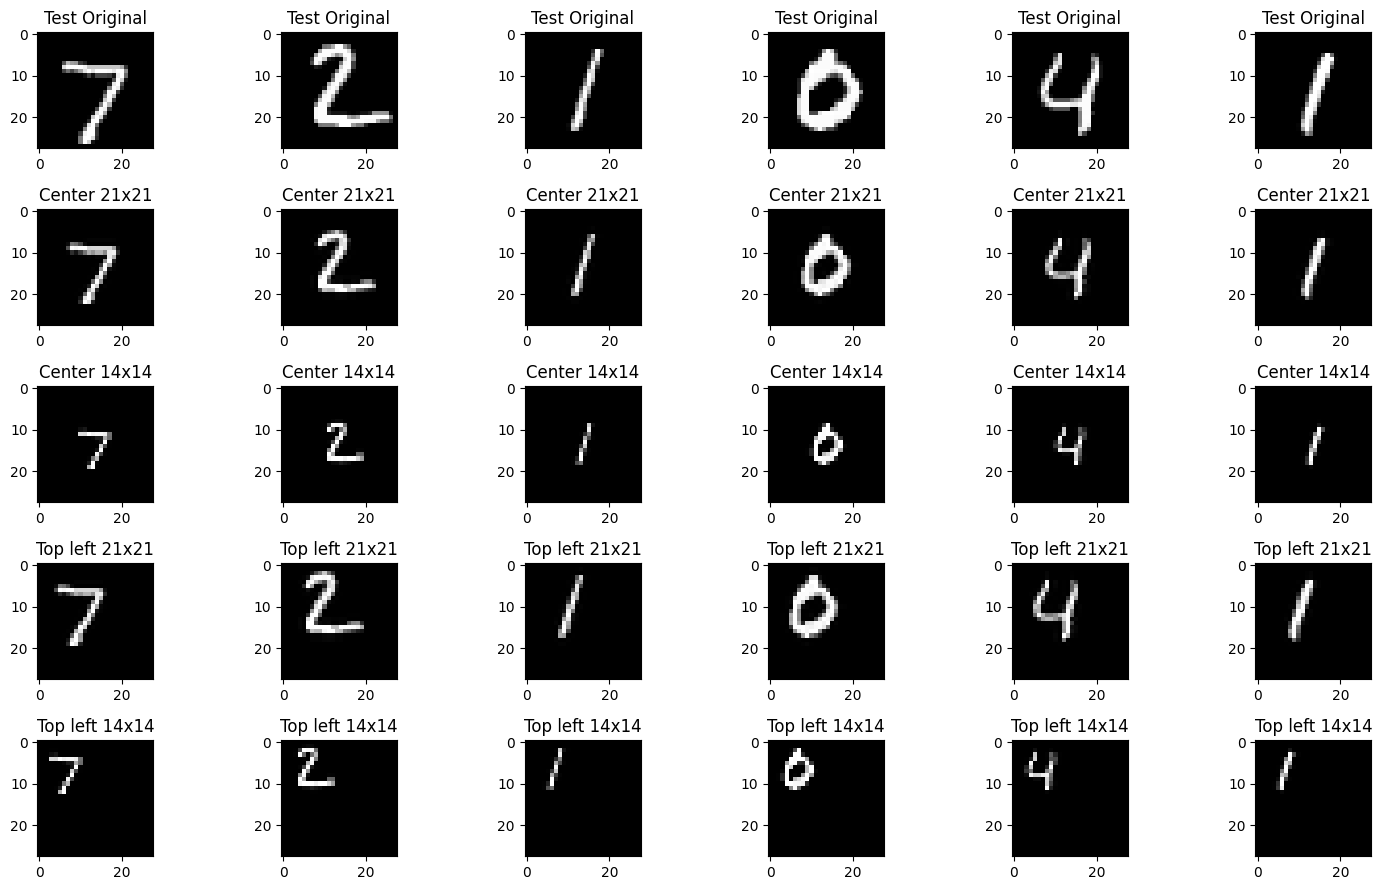

In [102]:
# Compress 28x28 data into 21x21 data
def compress_to_21x21(images):
    compressed_images = []
    for image in images:
        compressed_image = zoom(image, (0.75, 0.75))  # 28x28 -> 21x21
        compressed_images.append(compressed_image)
    return np.array(compressed_images)

# Compress 28x28 data into 14x14 data
def compress_to_14x14(images):
    compressed_images = []
    for image in images:
        compressed_image = zoom(image, (0.5, 0.5))  # 28x28 -> 14x14
        compressed_images.append(compressed_image)
    return np.array(compressed_images)

# Put the compressed 21x21 data into the center of 28x28
def embed_in_center_21x21(compressed_images):
    new_images = []
    for compressed_image in compressed_images:
        new_image = np.zeros((28, 28))
        new_image[3:24, 3:24] = compressed_image  # not 100% center aligned but it is OK  
        new_images.append(new_image)
    return np.array(new_images)

# Put the compressed 14x14 data into the center of 28x28
def embed_in_center_14x14(compressed_images):
    new_images = []
    for compressed_image in compressed_images:
        new_image = np.zeros((28, 28))
        new_image[7:21, 7:21] = compressed_image  # center aligned
        new_images.append(new_image)
    return np.array(new_images)

# Put the compressed 21x21 data into the top left corner of 28x28
def embed_in_top_left_21x21(compressed_images):
    new_images = []
    for compressed_image in compressed_images:
        new_image = np.zeros((28, 28))
        new_image[:21, :21] = compressed_image  # top left 9/16 area
        new_images.append(new_image)
    return np.array(new_images)

# Put the compressed 14x14 data into the top left corner of 28x28
def embed_in_top_left_14x14(compressed_images):
    new_images = []
    for compressed_image in compressed_images:
        new_image = np.zeros((28, 28))
        new_image[:14, :14] = compressed_image  # top left 1/4 area
        new_images.append(new_image)
    return np.array(new_images)


train_images_all = X_train[:60000]
test_images_all = X_test[:10000]
#compress data and align position
train_compressed_images21 = compress_to_21x21(train_images_all)
train_new_images21_center = embed_in_center_21x21(train_compressed_images21)
train_new_images21_top_left = embed_in_top_left_21x21(train_compressed_images21)

test_compressed_images21 = compress_to_21x21(test_images_all)
test_new_images21_center = embed_in_center_21x21(test_compressed_images21)
test_new_images21_top_left = embed_in_top_left_21x21(test_compressed_images21)

train_compressed_images14 = compress_to_14x14(train_images_all)
train_new_images14_center = embed_in_center_14x14(train_compressed_images14)
train_new_images14_top_left = embed_in_top_left_14x14(train_compressed_images14)

test_compressed_images14 = compress_to_14x14(test_images_all)
test_new_images14_center = embed_in_center_14x14(test_compressed_images14)
test_new_images14_top_left = embed_in_top_left_14x14(test_compressed_images14)


# Use first 6 pictures as image view test
# For Train Data
fig, axes = plt.subplots(5, 6, figsize=(15, 9))
for i, (original, new21tl, new14tl, new21c, new14c) in enumerate(zip(train_images_all[:6], train_new_images21_top_left, train_new_images14_top_left, train_new_images21_center, train_new_images14_center)):
    j=0
    axes[j, i].imshow(original.squeeze(), cmap='gray')
    axes[j, i].set_title('Train Original')
    j+=1
    axes[j, i].imshow(new21c.squeeze(), cmap='gray')
    axes[j, i].set_title('Center 21x21')
    j+=1
    axes[j, i].imshow(new14c.squeeze(), cmap='gray')
    axes[j, i].set_title('Center 14x14')
    j+=1
    axes[j, i].imshow(new21tl.squeeze(), cmap='gray')
    axes[j, i].set_title('Top left 21x21')
    j+=1
    axes[j, i].imshow(new14tl.squeeze(), cmap='gray')
    axes[j, i].set_title('Top left 14x14')
plt.tight_layout()
plt.show()

# For Test Data
fig, axes = plt.subplots(5, 6, figsize=(15, 9))
for i, (original, new21tl, new14tl, new21c, new14c) in enumerate(zip(test_images_all[:6], test_new_images21_top_left, test_new_images14_top_left, test_new_images21_center, test_new_images14_center)):
    j=0
    axes[j, i].imshow(original.squeeze(), cmap='gray')
    axes[j, i].set_title('Test Original')
    j+=1
    axes[j, i].imshow(new21c.squeeze(), cmap='gray')
    axes[j, i].set_title('Center 21x21')     # Almost center
    j+=1
    axes[j, i].imshow(new14c.squeeze(), cmap='gray')
    axes[j, i].set_title('Center 14x14')
    j+=1
    axes[j, i].imshow(new21tl.squeeze(), cmap='gray')
    axes[j, i].set_title('Top left 21x21')
    j+=1
    axes[j, i].imshow(new14tl.squeeze(), cmap='gray')
    axes[j, i].set_title('Top left 14x14')
plt.tight_layout()
plt.show()

For all the 5 kinds of train data and the 5 kinds of test data generated, we standardize and reshpse the data.
- Standardize the data range from 0-255 to 0-1
- Reshape the data format from 28x28 pixels to 784 pixels (flat)
- Transform the axis.

In [103]:
X_train_std = X_train / 255                         # Standardise between 0-1 from 0-255
X_test_std = X_test / 255                           # Standardise between 0-1 from 0-255
X_train_s_784 = X_train_std.reshape(60000, 28*28)   # Put the all data in one flat line.
X_train_s_784_t = X_train_s_784.T
X_test_s_784 = X_test_std.reshape(10000, 28*28)
X_test_s_784_t = X_test_s_784.T
print(X_train_s_784_t.shape)
print(X_test_s_784_t.shape)
print(Y_train.shape)

train_new_images_s_21_center = train_new_images21_center / 255
test_new_images_s_21_center = test_new_images21_center / 255
X_train_new_s_784_21_c = train_new_images_s_21_center.reshape(60000, 28*28)
X_train_new_s_784_21_c_t = X_train_new_s_784_21_c.T
X_test_new_s_784_21_c = test_new_images_s_21_center.reshape(10000, 28*28)
X_test_new_s_784_21_c_t = X_test_new_s_784_21_c.T

train_new_images_s_14_center = train_new_images14_center / 255
test_new_images_s_14_center= test_new_images14_center / 255
X_train_new_s_784_14_c = train_new_images_s_14_center.reshape(60000, 28*28)
X_train_new_s_784_14_c_t = X_train_new_s_784_14_c.T
X_test_new_s_784_14_c = test_new_images_s_14_center.reshape(10000, 28*28)
X_test_new_s_784_14_c_t = X_test_new_s_784_14_c.T

train_new_images_s_21_top_left = train_new_images21_top_left / 255
test_new_images_s_21_top_left = test_new_images21_top_left / 255
X_train_new_s_784_21_tl = train_new_images_s_21_top_left.reshape(60000, 28*28)
X_train_new_s_784_21_tl_t = X_train_new_s_784_21_tl.T
X_test_new_s_784_21_tl = test_new_images_s_21_top_left.reshape(10000, 28*28)
X_test_new_s_784_21_tl_t = X_test_new_s_784_21_tl.T

train_new_images_s_14_top_left = train_new_images14_top_left / 255
test_new_images_s_14_top_left = test_new_images14_top_left / 255
X_train_new_s_784_14_tl = train_new_images_s_14_top_left.reshape(60000, 28*28)
X_train_new_s_784_14_tl_t = X_train_new_s_784_14_tl.T
X_test_new_s_784_14_tl = test_new_images_s_14_top_left.reshape(10000, 28*28)
X_test_new_s_784_14_tl_t = X_test_new_s_784_14_tl.T

(784, 60000)
(784, 10000)
(60000,)


### 3.	Model Generation
#### Constructing a Neural Network Model
##### Create a neural network model from scratch with a 1- or 2-hidden-layer architecture.

One of the challenges of using TensorFlow Keras-based models is their lack of flexibility. In this project, the model parameters, Wx and bx, need to be updated based on the input data during the model's use stage, which is not possible with the default TensorFlow Keras models. Therefore, I decided to create the model from scratch. The code linked below was used as a reference:


    Simple MNIST NN from scratch (numpy, no TF/Keras)
    https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras

In [139]:
# All function defitions

# The final output layer width should be 10 for number recognition.
# Example of setting
#1 layer: set 20, 10, 0
#2 layer: set 20, 10, 10

def init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width):       # Parameters for 2 hidlayers
    np.random.seed(42)   #
    W1 = np.random.rand(Layer_1_Width, 784) - 0.5
    b1 = np.random.rand(Layer_1_Width, 1) - 0.5
    W2 = np.random.rand(Layer_2_Width, Layer_1_Width) - 0.5
    b2 = np.random.rand(Layer_2_Width, 1) - 0.5 
    if Layer_3_Width == 0:
        W3 = 0
        b3 = 0
    else:
        W3 = np.random.rand(Layer_3_Width, Layer_2_Width) - 0.5
        b3 = np.random.rand(Layer_3_Width, 1) - 0.5
    return W1, b1, W2, b2, W3, b3

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop_ReLU(X, W, b):
    Z = W.dot(X) + b
    A = ReLU(Z)
    return Z, A

def forward_prop_Softmax(X, W, b):
    Z = W.dot(X) + b
    A = softmax(Z)
    return Z, A

def forward_prop(X, W1, b1, W2, b2):   # Here, does not matter whether we use Wo or W2
    Z1, A1 = forward_prop_ReLU(X, W1, b1)
    Z2, A2 = forward_prop_Softmax(A1, W2, b2)
    return Z1, A1, Z2, A2

def forward_prop2(X, W1, b1, W2, b2, W3, b3):   # Here, does not matter whether we use Wo or W3
    Z1, A1 = forward_prop_ReLU(X, W1, b1)
    Z2, A2 = forward_prop_ReLU(A1, W2, b2)
    Z3, A3 = forward_prop_Softmax(A2, W3, b3)
    return Z1, A1, Z2, A2, Z3, A3

def ReLU_deriv(Z):
    return Z > 0  # return 1 if z > 0, return 0 if z >= 0

def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((Y.size, num_classes))    # Updated with num_classs = 10 should be always last layer width, which is 10.
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop_ReLU(bp_m, bp_A0, bp_Z1, bp_W2, bp_dZ2):    # Here order is used so it is OK to stay with A0, Z1, W2 and so forth rather than using Wo.
    bp_dZ1 = bp_W2.T.dot(bp_dZ2) * ReLU_deriv(bp_Z1)
    bp_dW1 = 1 / bp_m * bp_dZ1.dot(bp_A0.T)
    bp_db1 = 1 / bp_m * np.sum(bp_dZ1)
    return bp_dZ1, bp_dW1, bp_db1

def backward_prop_Softmax(m, A1, A2, Y):    # Here order is used so it is OK to stay with A1, A2, and so forth rather than using Ao.
    #one_hot_Y = one_hot(Y, A2.shape[0])
    one_hot_Y = one_hot(Y, 10)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    return dZ2, dW2, db2

def backward_prop(m, X, W1, Z1, A1, W2, Z2, A2, Y):    # Here to make it simple, to stay using A2
    dZ2, dW2, db2 = backward_prop_Softmax(m, A1, A2, Y)  
    dZ1, dW1, db1 = backward_prop_ReLU(m, X, Z1, W2, dZ2)
    return dW1, db1, dW2, db2

def backward_prop2(m, X, W1, Z1, A1, W2, Z2, A2, W3, Z3, A3, Y):    # Here to make it simple, to stay using A3
    dZ3, dW3, db3 = backward_prop_Softmax(m, A2, A3, Y)
    dZ2, dW2, db2 = backward_prop_ReLU(m, A1, Z2, W3, dZ3)  
    dZ1, dW1, db1 = backward_prop_ReLU(m, X, Z1, W2, dZ2)  
    return dW1, db1, dW2, db2, dW3, db3

def update_params(W1, b1, dW1, db1, W2, b2, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2
    
    #w = w + 0.1*(y - predictions)@Xt
    
def update_params2(W1, b1, dW1, db1, W2, b2, dW2, db2, W3, b3, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3
                    
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def get_predictions_probabilities2(X, W1, b1, W2, b2, W3, b3, layer):
    if layer == 1:
        _, _, _, A = forward_prop(X, W1, b1, W2, b2)
    else:   # This means layer == 2:
        _, _, _, _, _, A = forward_prop2(X, W1, b1, W2, b2, W3, b3) 
    predictions = np.argmax(A, 0)
    probabilities = A[predictions, range(A.shape[1])]
    return predictions, probabilities

def show_prediction2(X, Y, index, num_data, W1, b1, W2, b2, W3, b3, layer):    # Use only when we want to see a spefici data prediction after train.
    current_image = X[:, index, None]
    prediction, probability = get_predictions_probabilities2(X[:, index, None], W1, b1, W2, b2, W3, b3, layer)
    label = Y[index]
    print("Prediction: ", prediction)
    print("Probability: ", probability)
    print("Label: ", label)        
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

def show_predictions2(X, Y, index, num_data, W1, b1, W2, b2, W3, b3, layer):    # Use only when we want to see a spefici data prediction after train.
    for i in range(num_data):
        current_image = X[:, index+i, None]
        predictions, probabilities = get_predictions_probabilities2(X[:, index+i, None], W1, b1, W2, b2, W3, b3, layer)
        label = Y[index:index+num_data]
        print("Prediction: ", predictions)
        print("Probability: ", probabilities)
        print("Label: ", label[i])
        
        current_image = current_image.reshape((28, 28)) * 255
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()

def gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epochs, record, predict_learn):
    results_all_df = pd.DataFrame()
    prediction_probabilities_df = pd.DataFrame()
    nX, mX = X.shape  # mX is for example 60000 or 180000.
    split = mX//batch   # If batch is 60000, then split is 1. 
                        # If batch is 100, then split is 600.
                        # If batch is 1, then split is 60000.
                        
    # This is for the combination of the data and like to split for batch size (= data size / split). If split = 1, no split. 
    # This implementation does not have an exception code to catch the case that the data size is not devisible by split to make batch size. Keep in mind batch size should be INT.
    split_arrays = np.hsplit(X, split)
    X_split = np.array(split_arrays)    # If split = 3 is used for example, then X_split[0], X_split[1], and X_split[2] are generated.
    split_arrays = np.hsplit(Y, split)  
    Y_split = np.array(split_arrays)    # If split = 3 is used for example, then Y_split[0], Y_split[1], and Y_split[2] are generated.   

    m = batch
    num = 20
    
    for i in range(epochs):         # Epoch.
     
        dW1, db1, dW2, db2, dW3, db3, Z1, A1, Z2, A2 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

        if i % record == 0:         # every record (such as 25 etc.) epoch store a temporaly set of results.
            predictions, probabilities = get_predictions_probabilities2(X_train_s_784_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_train = get_accuracy(predictions, Y_train)
            predictions, probabilities = get_predictions_probabilities2(X_test_s_784_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_test = get_accuracy(predictions, Y_test)
            predictions, probabilities = get_predictions_probabilities2(X_train_new_s_784_14_tl_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_train_new_s_784_14_tl_t = get_accuracy(predictions, Y_train)
            predictions, probabilities = get_predictions_probabilities2(X_test_new_s_784_14_tl_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_test_new_s_784_14_tl_t = get_accuracy(predictions, Y_test)
            predictions, probabilities = get_predictions_probabilities2(X_train_new_s_784_21_tl_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_train_new_s_784_21_tl_t = get_accuracy(predictions, Y_train)
            predictions, probabilities = get_predictions_probabilities2(X_test_new_s_784_21_tl_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_test_new_s_784_21_tl_t = get_accuracy(predictions, Y_test)
            predictions, probabilities = get_predictions_probabilities2(X_train_new_s_784_14_c_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_train_new_s_784_14_c_t = get_accuracy(predictions, Y_train)
            predictions, probabilities = get_predictions_probabilities2(X_test_new_s_784_14_c_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_test_new_s_784_14_c_t = get_accuracy(predictions, Y_test)
            predictions, probabilities = get_predictions_probabilities2(X_train_new_s_784_21_c_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_train_new_s_784_21_c_t = get_accuracy(predictions, Y_train)
            predictions, probabilities = get_predictions_probabilities2(X_test_new_s_784_21_c_t, W1, b1, W2, b2, W3, b3, layer)
            accuracy_X_test_new_s_784_21_c_t = get_accuracy(predictions, Y_test)           
            
            results_all_df = results_all_df.append({'Index': i,
                                            'X_train': accuracy_X_train, 'X_test': accuracy_X_test,
                                            'X_train_21_c': accuracy_X_train_new_s_784_21_c_t, 'X_test_21_c': accuracy_X_test_new_s_784_21_c_t,
                                            'X_train_14_c': accuracy_X_train_new_s_784_14_c_t, 'X_test_14_c': accuracy_X_test_new_s_784_14_c_t,
                                            'X_train_21_tl': accuracy_X_train_new_s_784_21_tl_t, 'X_test_21_tl': accuracy_X_test_new_s_784_21_tl_t,
                                            'X_train_14_tl': accuracy_X_train_new_s_784_14_tl_t, 'X_test_14_tl': accuracy_X_test_new_s_784_14_tl_t,
                                            'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'Z1':Z1, 'A1':A1, 'Z2':Z2, 'A2':A2
                                            }, ignore_index=True)
            
           
        for j in range(split):      # j goes through 0-9999:split (10000): total data set (e.g. 10000) = (e.g. 30000) / batch size (e.g. 3)) 
            Xj = X_split[j]
            Yj = Y_split[j]
            
            # Every Xj has e.g. 3 data points (X0_j, X1_j, X2_j)
            
            if predict_learn != 0:     # Here every single test, predict/newly define Yj on the fly and use that Yj to execute the backward propagation.
                predictions, probabilities = get_predictions_probabilities2(Xj, W1, b1, W2, b2, W3, b3, layer)
                
                if predict_learn == 1:     # Here every single test, predict/newly define Yj on the fly and use that Yj to execute the backward propagation.
                    Yj = predictions    # overwritten by on the fly prediction.
                # In this case, we just use predications
                
                if predict_learn == 2:
                    predictions_max = np.full_like(predictions, predictions[np.argmax(probabilities)])
                    Yj = predictions_max    # overwritten by on the fly prediction.
                # Keep in mind to use only with split that is aligned with the data connection strucuture.
                # For example if batch = 3, then X0_0, X1_0, X2_0 inputs will be used to get a prediction and probability for each of these three inputs.
                
                if j < num:
                    prediction_probabilities_df = prediction_probabilities_df.append({'epoch_i': i, 'split_j': j,
                            'Predictions': predictions, 'Probabilities': probabilities,
                            }, ignore_index=True)

            if layer == 1:
                Z1, A1, Z2, A2 = forward_prop(Xj, W1, b1, W2, b2)
                dW1, db1, dW2, db2 = backward_prop(m, Xj, W1, Z1, A1, W2, Z2, A2, Yj)
                W1, b1, W2, b2 = update_params(W1, b1, dW1, db1, W2, b2, dW2, db2, alpha)
                
            if layer == 2:
                Z1, A1, Z2, A2, Z3, A3 = forward_prop2(Xj, W1, b1, W2, b2, W3, b3)
                dW1, db1, dW2, db2, dW3, db3 = backward_prop2(m, Xj, W1, Z1, A1, W2, Z2, A2, W3, Z3, A3, Yj)
                W1, b1, W2, b2, W3, b3 = update_params2(W1, b1, dW1, db1, W2, b2, dW2, db2, W3, b3, dW3, db3, alpha)
                
    #return results_all_df
    return results_all_df, prediction_probabilities_df

In [105]:
def graph(results_df, title):

    plt.figure(figsize=(14, 8))

    plt.plot(results_df['Index'], results_df['X_train'], label=f'Train Accuracy          {results_df.iloc[-1, 1]*100:.1f}%')
    plt.plot(results_df['Index'], results_df['X_test'], label=f'Test Accuracy            {results_df.iloc[-1, 2]*100:.1f}%', linestyle='--')
    plt.plot(results_df['Index'], results_df['X_train_21_c'], label=f'Train Accuracy 21 C  {results_df.iloc[-1, 3]*100:.1f}%')
    plt.plot(results_df['Index'], results_df['X_test_21_c'], label=f'Test Accuracy 21 C    {results_df.iloc[-1, 4]*100:.1f}%', linestyle='--')
    plt.plot(results_df['Index'], results_df['X_train_14_c'], label=f'Train Accuracy 14 C  {results_df.iloc[-1, 5]*100:.1f}%')
    plt.plot(results_df['Index'], results_df['X_test_14_c'], label=f'Test Accuracy 14 C    {results_df.iloc[-1, 6]*100:.1f}%', linestyle='--')
    plt.plot(results_df['Index'], results_df['X_train_21_tl'], label=f'Train Accuracy 21 TL  {results_df.iloc[-1, 7]*100:.1f}%')
    plt.plot(results_df['Index'], results_df['X_test_21_tl'], label=f'Test Accuracy 21 TL    {results_df.iloc[-1, 8]*100:.1f}%', linestyle='--')
    plt.plot(results_df['Index'], results_df['X_train_14_tl'], label=f'Train Accuracy 14 TL  {results_df.iloc[-1, 9]*100:.1f}%')
    plt.plot(results_df['Index'], results_df['X_test_14_tl'], label=f'Test Accuracy 14 TL    {results_df.iloc[-1, 10]*100:.1f}%', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Test Accuracy: {title}')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.0)
    plt.show()
    #print(results_df.iloc[-1, :])

In [107]:
def sub_plot(x, Layer_x_Width, Wx_2D, bx_2D, Wx_name, bx_name):
    fig, axes = plt.subplots(x, Layer_x_Width//x, figsize=(15, 3))
    if x == 1:
        for i, weight1 in enumerate(Wx_2D[:Layer_x_Width]):
            axes[i].imshow(weight1, cmap='Blues')
            axes[i].set_title(f'{Wx_name}_{i}')
    else:
        for i, weight1 in enumerate(Wx_2D[:Layer_x_Width]):
            j = i//(Layer_x_Width//x)
            k = i%(Layer_x_Width//x)
            axes[j, k].imshow(weight1, cmap='Blues')
            axes[j, k].set_title(f'{Wx_name}_{i}')
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(1, 1, figsize=(5, 1))
    axes.imshow(bx_2D, cmap='Blues')
    axes.set_title(f'{bx_name}')
    axes.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))
    axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))
    plt.tight_layout()
    plt.show()


def graph_perceptron_l2(title, W1, b1, W2, b2, W3, b3, Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only):# Define a function to show weights of perceptrons 
    #plt.figure(figsize=(15, 5))
    #plt.suptitle(title)
    #plt.show()
    print(title)

    W1_2D = W1.reshape(Layer_1_Width, 28, 28)
    b1_2D = b1.reshape(a, Layer_1_Width//a)

    W2_2D = W2.reshape(Layer_2_Width, a, Layer_1_Width//a)
    b2_2D = b2.reshape(b, Layer_2_Width//b)
    
    if Layer_3_Width != 0:
        W3_2D = W3.reshape(Layer_3_Width, b, Layer_2_Width//b)
        b3_2D = b3.reshape(c, Layer_3_Width//c)
    
    sub_plot(a, Layer_1_Width, W1_2D, b1_2D, "W1", "b1")
    if graph_W1_only == 0:
        sub_plot(b, Layer_2_Width, W2_2D, b2_2D, "W2", "b2")
        if Layer_3_Width != 0:
            sub_plot(c, Layer_3_Width, W3_2D, b3_2D, "W3", "b3")
            
            

In [108]:
columns = ['results_df']
resultset_df = pd.DataFrame(columns=columns)
resultset_df

,results_df


### 4.	Model Application

#### Applying Nural Network Model

##### Apply the neural network model with different parameter settings and monitor accuracy.

##### (1)	Standard Model Evaluation
Several standard models are evaluated to decide which model to use for the on-the-fly learning.


**Standard Model Test Results (Model 1 - 11)**

(Model 1) Base parameters:

- 93.7% accuracy
- The initial W1 is randomly assgined. As epoch goes, W1 is being evolved with some specific shapes. W1 @ Epoch 10 is already some how similar to W1 final (60), which indicates the training is almost sopisticated when Epoch is 10 and that is confirmed from the acccuary (90%+) on the graph @ Epoch 10 as well. 
- b1, W2, and b2 are a little bit difficult desipher the evolution but b1 and b2 are not that much changed a lot.
- As for the application to modified test data set, 21C is relatively good but not good at all for 14C, 21tl, and 14tl.

In [140]:
def default_settings():
    X = X_train_s_784_t     # Training Data Set
    Y = Y_train             # Training Data Set
    layer = 1               # Number of Hidden Layer (1 or 2 can be selectable)
    Layer_1_Width = 10      # 1st hidden layer for all models.
    Layer_2_Width = 10      # 2nd hidden layer for 2 hidden layer model. Final output layer for 1 hidden layer model. 
    Layer_3_Width = 0       # Final output layer for 2 hidden layer model. ==>> Put 0 in case of 1 hidden layer.

    batch = 100             # Batch size
    alpha = 0.10            # Can tune the learning rate
    epoch = 60+1            # Want to see the result of both ends (for example 0 and 60 in case 61)
    record = 1              # Granurarity of graph record. 1 for better resolution of graph (). 10 for quick execution. ()
    fp = final_point = (epoch-1)/record # Just for graph purpose
    a = 1                   # 1st layer W1 graph lines: Just for graph purpose
    b = 1                   # 2nd layer W2 graph lines: Just for graph purpose
    c = 1                   # 3rd layer W3 graph lines: Just for graph purpose
    graph_W1_only = 1       # If 0, all graphs are displayed. If 1, no W2, b2 (or W3, b3) graphs are displayed
    predict_learn = 0          # 0: normal larning from scratch. 1: on the fly learning
    
    return X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn

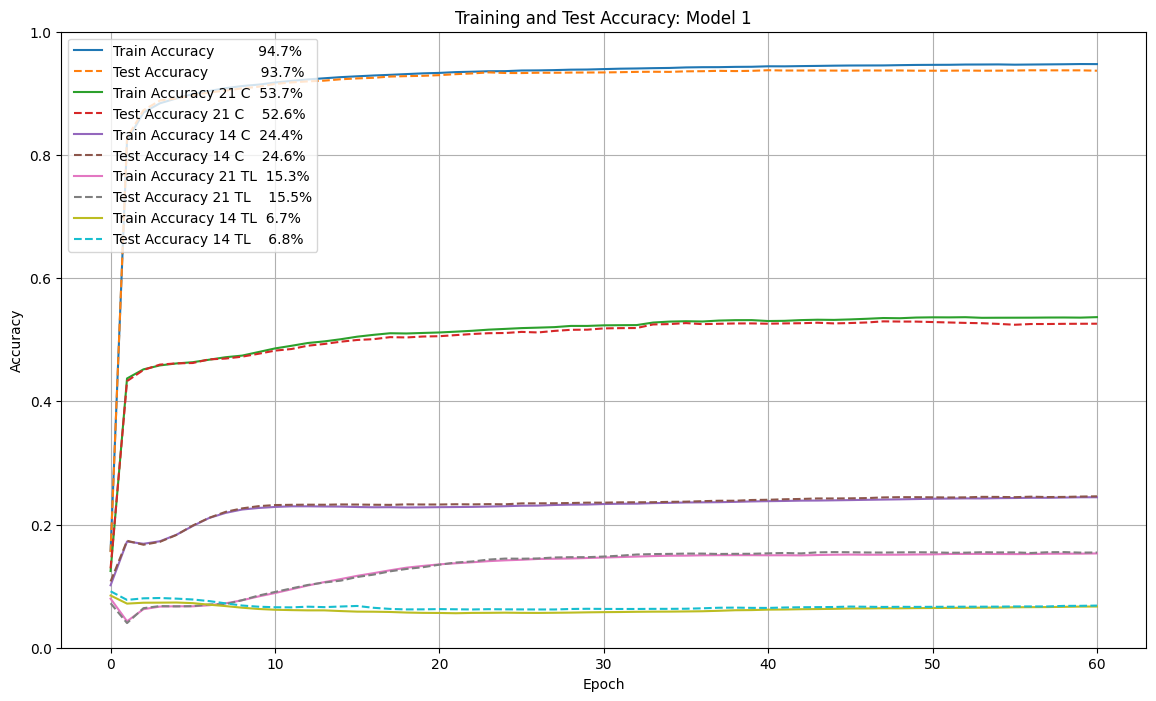

Epoch Initial


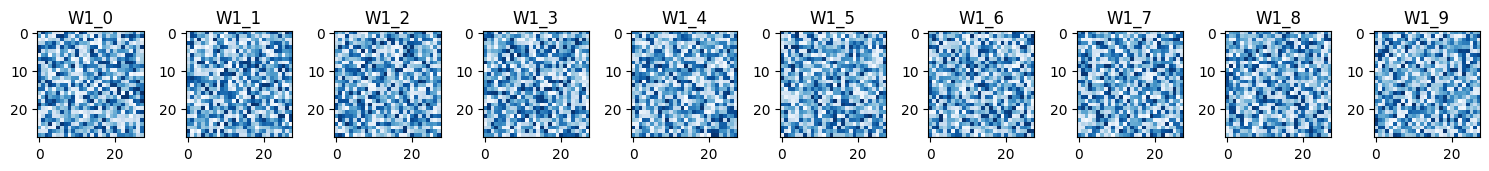

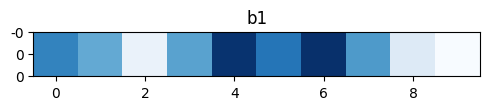

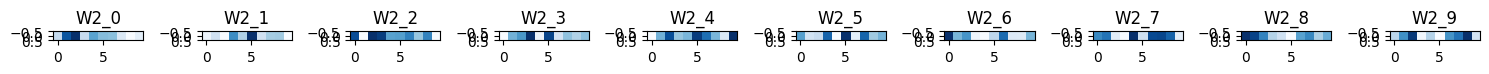

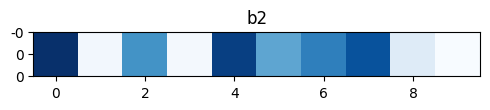

Epoch 5


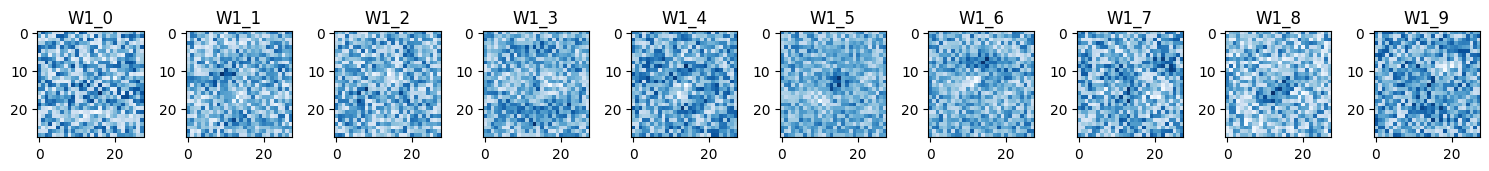

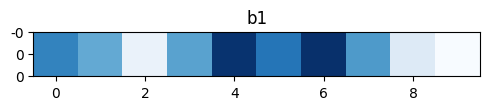

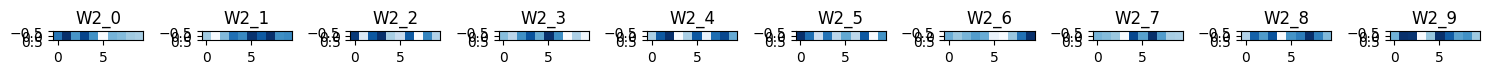

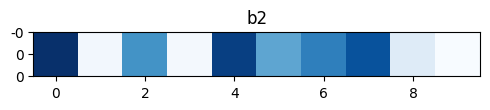

Epoch Final


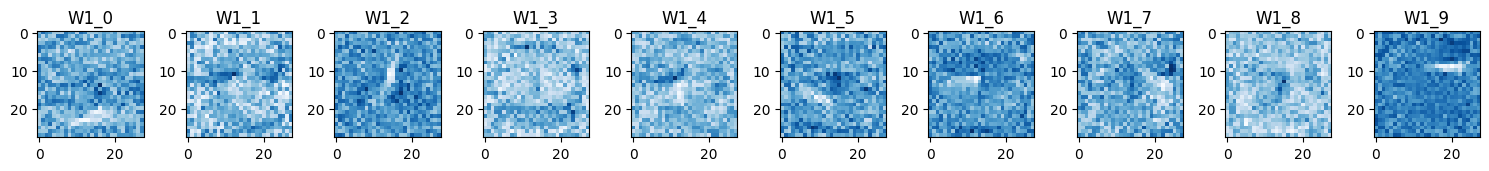

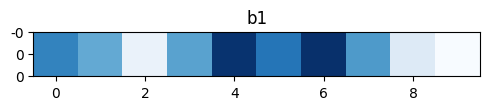

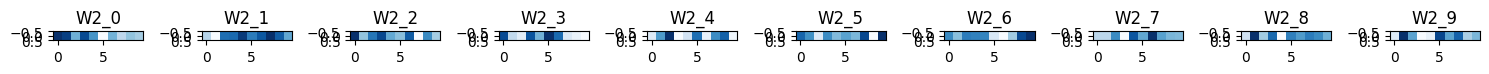

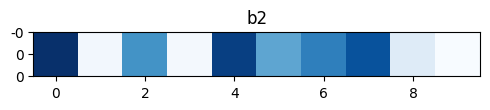

In [110]:
TestName = "Model 1"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
graph_W1_only = 0       # If 0, all graphs are displayed. If 1, no W2, b2 (or W3, b3) graphs are displayed

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Initial Epoch (This result is for the random parameters, so Wx, bx should be all ramdom numbers. )
graph_perceptron_l2("Epoch Initial", result.loc[0,"W1"], result.loc[0,"b1"], result.loc[0,"W2"], result.loc[0,"b2"], 
                    result.loc[0,"W3"], result.loc[0,"b3"], Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

n = 5

# nth Epoch
graph_perceptron_l2(f"Epoch {n}", result.loc[n,"W1"], result.loc[n,"b1"], result.loc[n,"W2"], result.loc[n,"b2"], 
                    result.loc[n,"W3"], result.loc[n,"b3"], Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)



(Model 2): (Model 1) + change the width of the 1st hidden layer from 10 to 20:

- 95.9% (20) vs 93.7% (10) a little bit of improvement, but not for non target data. This will be caused by 20 width will be lazer tuned for the specific target data compared to 10 width.
- The a lot of variety of shapes are observed.
- Evne taking a lot of calculation cost the result is not that improved. Maybe it is enough with 10 width.
Ohter notes:
- The initial accuracies are around 10% for all, which makes sense due to using the ramdom Wx, bx.

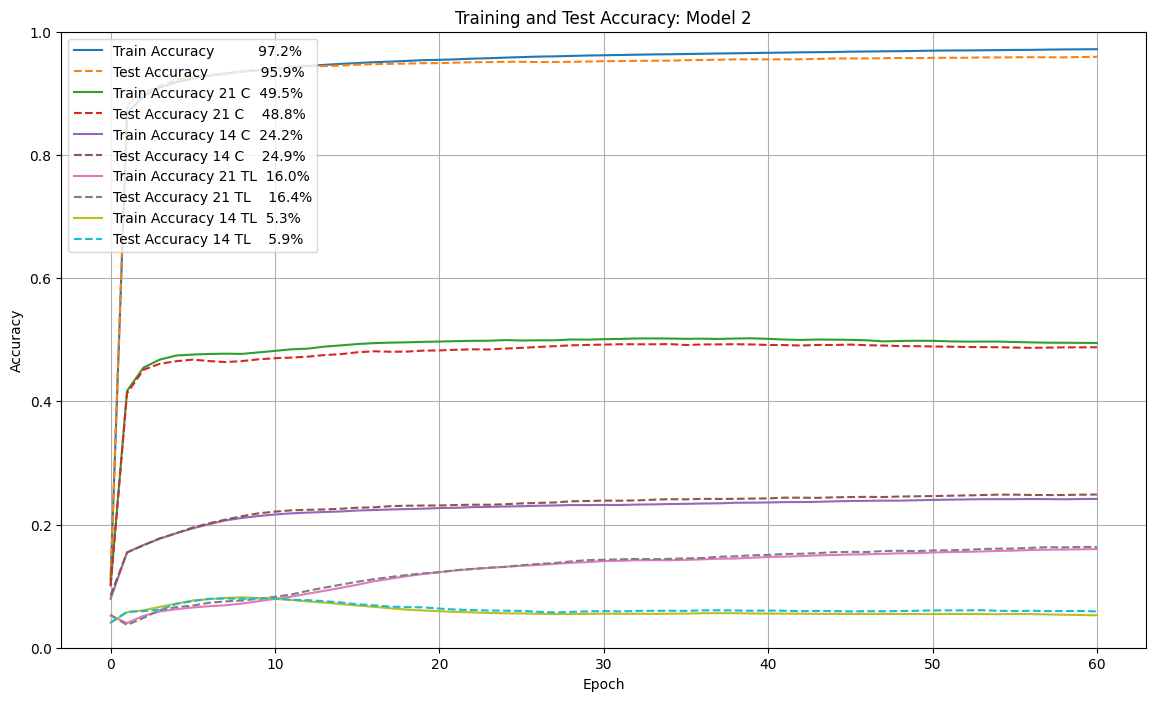

Epoch Final


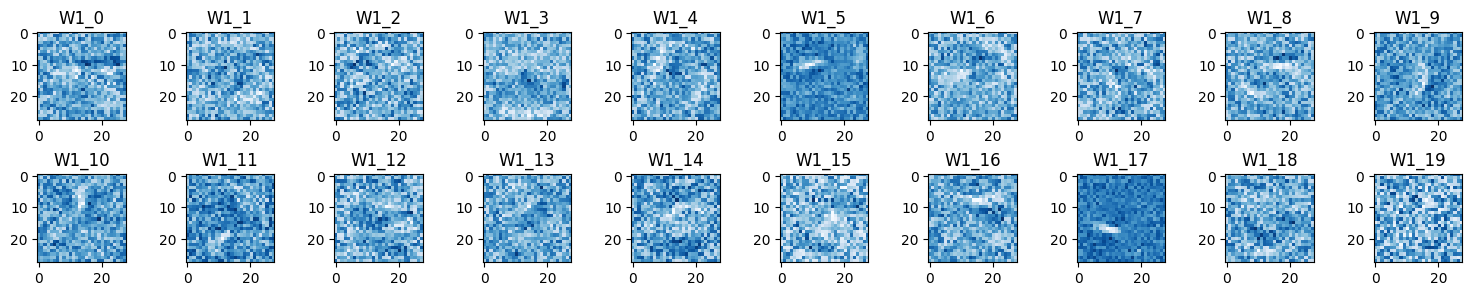

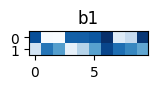

In [111]:
TestName = "Model 2"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
Layer_1_Width = 20      # 1st hidden layer for all models.  *********** THIS IS TEH CHANGE IN THIS MODEL ***********
a = 2                   # 1st layer W1 graph lines: Just for graph purpose

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)


(Model 3): (Model 1) + add 2nd hidden layer with 10 width

- 93.7% (Model 3) vs 93.7% (Model 1): Coincientally, the same accuracy.
- The a lot of variety of W1 shapes are observed.
- The result is not that improved. Maybe it is enough with 1 hidden layer.

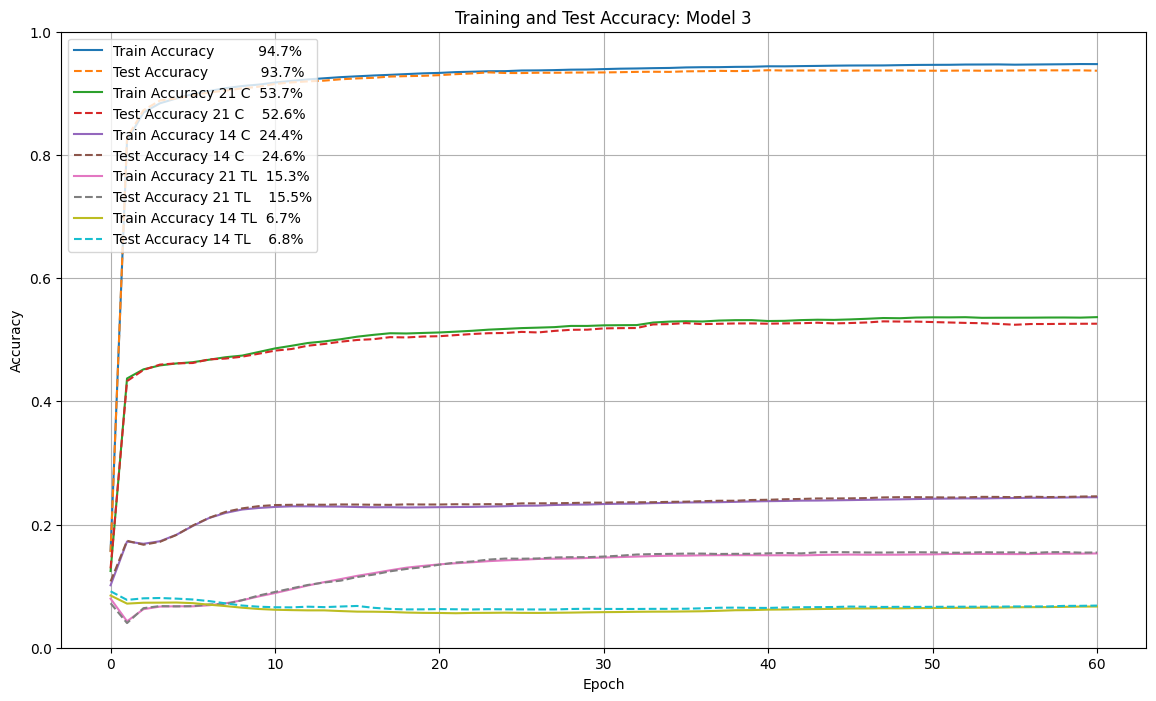

Epoch Final


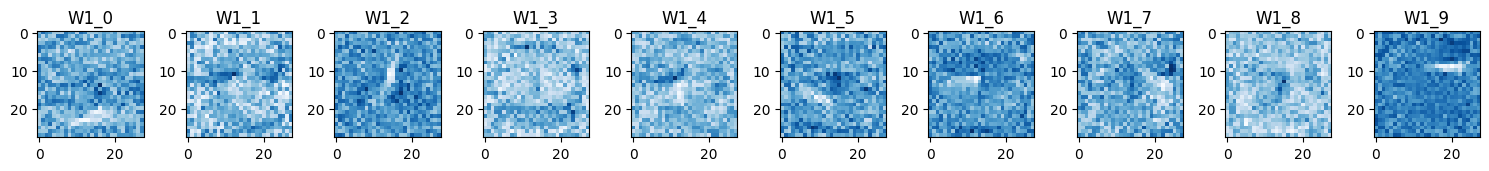

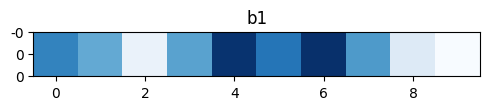

In [112]:
TestName = "Model 3"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
Layer_3_Width = 10       # Final output layer for 2 hidden layer model. ==>> Put 0 in case of 1 hidden layer.

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model 4): (Model 1) + batch size changed from 100 to 2 

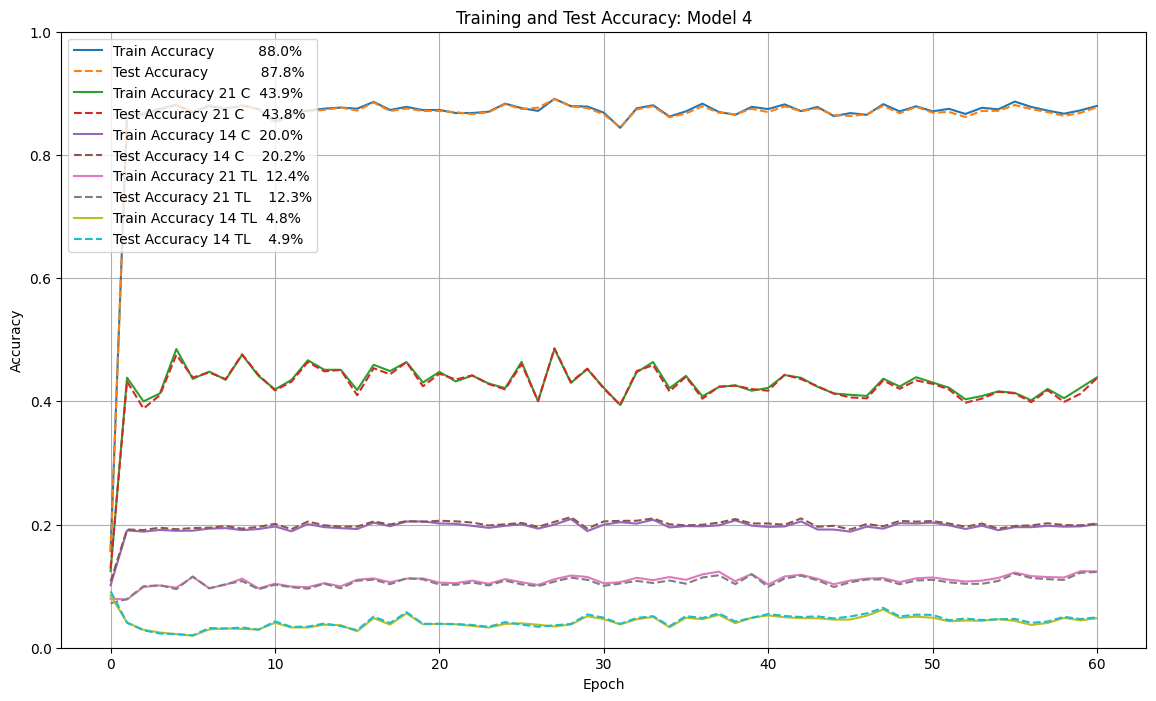

Epoch Final


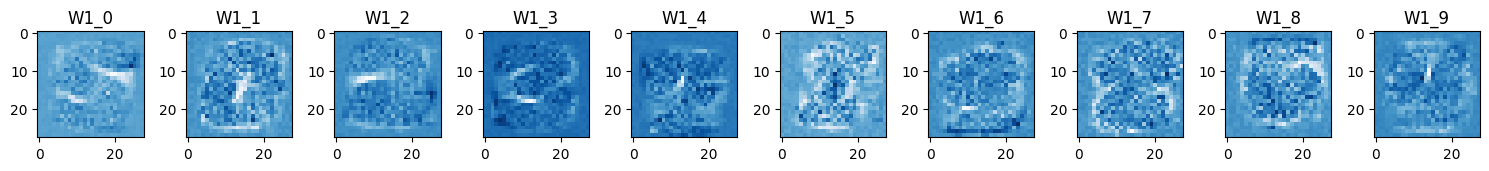

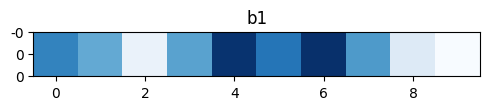

In [113]:
TestName = "Model 4"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
batch = 2             # Batch size     *********** THIS IS TEH CHANGE IN THIS MODEL ***********

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model 5): (Model 1) + batch size changed from 100 to 6000 
- 91.2% (Model 5) at 300 epoch vs 93.7% (Model 1) at 60 epoch: Accuracy improvement is very slow. The final accuracy is close to the origial one.
- A relatively smaller batch size like 100 well works. Too much precise learning steps does not benefit.

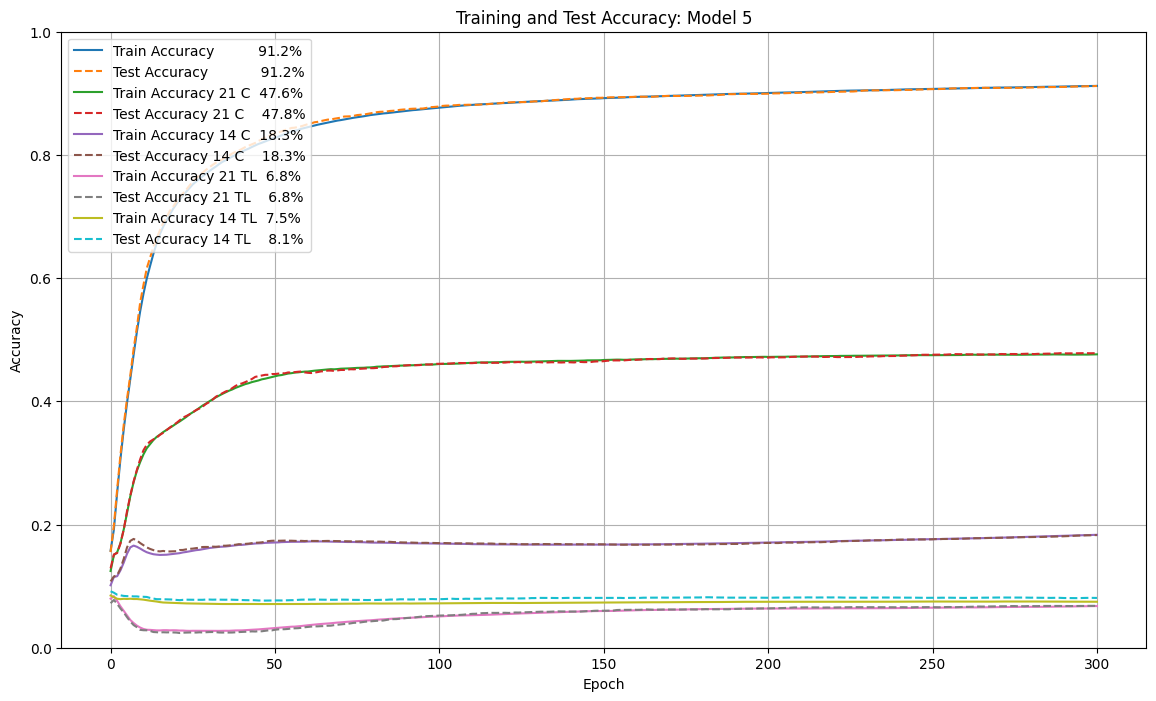

Epoch Final


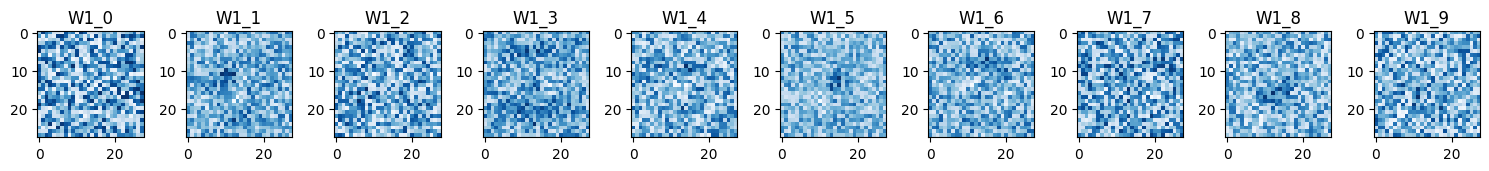

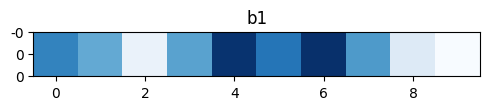

In [114]:
TestName = "Model 5"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
batch = 6000             # Batch size     *********** THIS IS TEH CHANGE IN THIS MODEL ***********
epoch = 300+1            # Want to see the result of both ends (for example 0 and 60 in case 61)  ******  Due to slow learning incresed from 60 to 300

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model 6): (Model 1) + train data changed from original to 21c

- 93.6% (Model 6) vs. 93.7% (Model 1) accuracy. Though the train data get smaller, the accuracy maintains the same level as the orinal one.
- W1 evolution can be seen only around 21x21 pixels at the center of 28x28 pixels

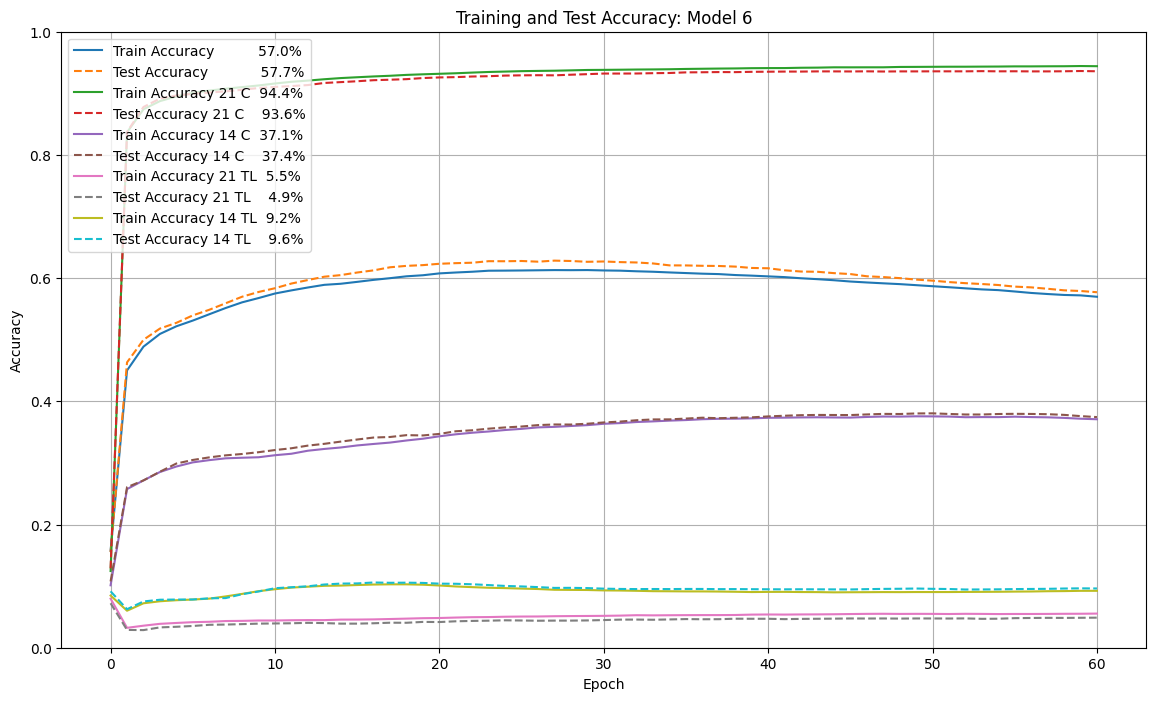

Epoch Final


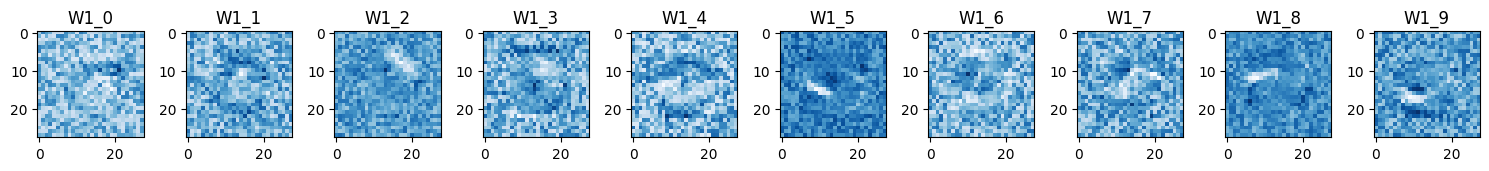

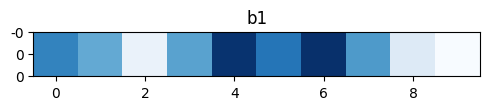

In [115]:
TestName = "Model 6"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_train_new_s_784_21_c_t    # Training Data Set      *************** Change here ******************

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model 7): (Model 1) + train data changed from original to 14c

- 92.7% (Model 7) vs. 93.7% (Model 1) accuracy. Though the train data get smaller, the accuracy maintains the same level as the orinal one.
- W1 evolution can be seen only around 14x14 pixels at the center of 28x28 pixels

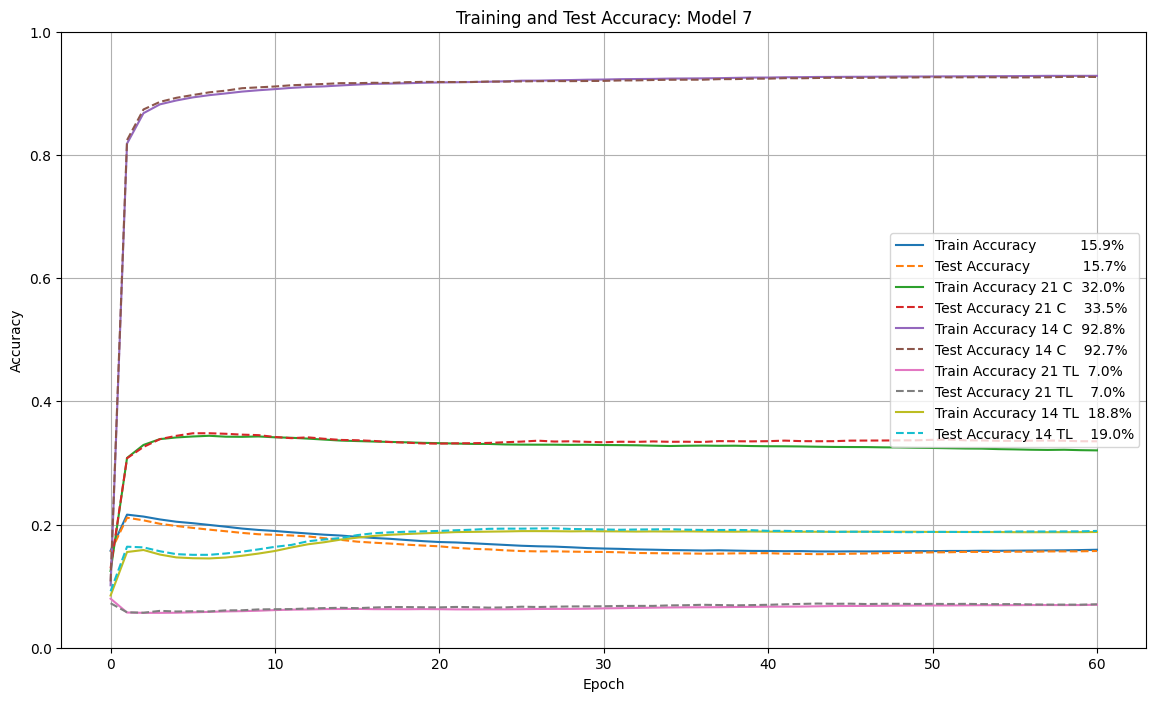

Epoch Final


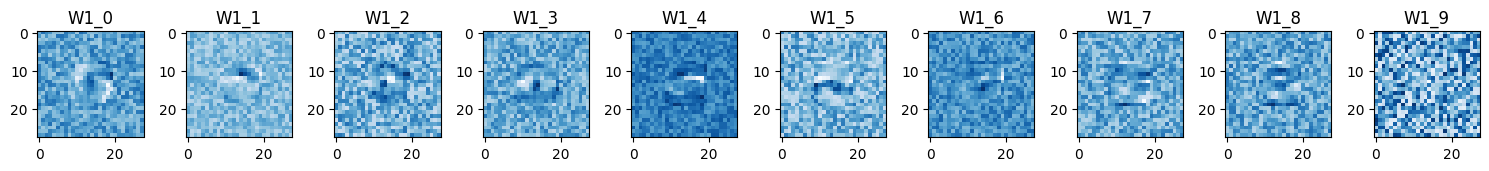

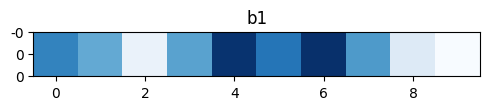

In [116]:
TestName = "Model 7"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_train_new_s_784_14_c_t   # *************** Change here ******************

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model 8): (Model 1) + train data changed from original to 21tl

- 93.8% (Model 8) vs. 93.7% (Model 1) accuracy. Though the train data get smaller, the accuracy maintains the same level as the orinal one.
- The above means no need for 28x28 resolution data but 21x21 is good enough.
- W1 evolution can be seen only around 21x21 pixels at the top left corner of 28x28 pixels

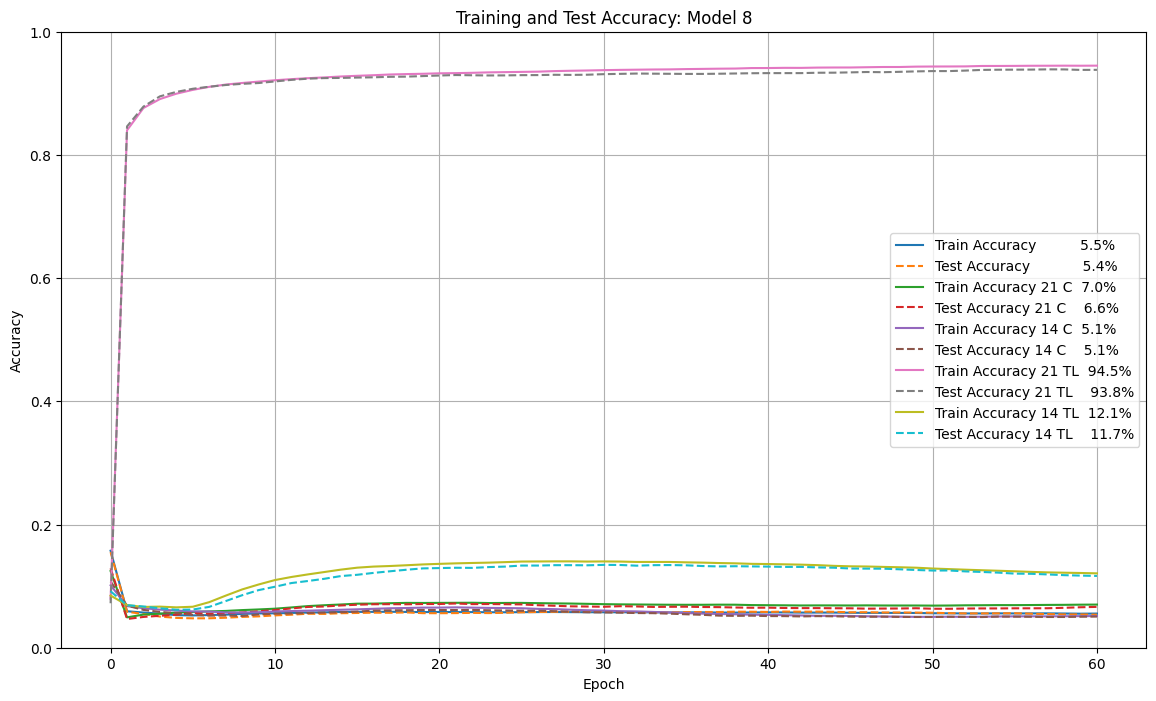

Epoch Final


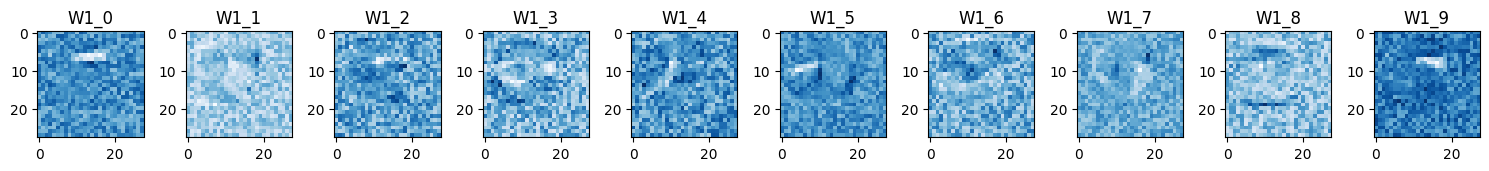

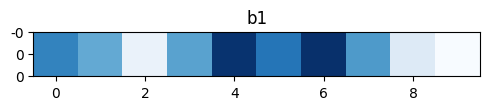

In [117]:
TestName = "Model 8"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_train_new_s_784_21_tl_t   # *************** Change here ******************

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model 9): (Model 1) + train data changed from original to 14tl

- 93.1% (Model 9) vs. 93.7% (Model 1) accuracy. Though the train data get smaller, the accuracy maintains the same level as the orinal one.
- W1 evolution can be seen only around 14x14 pixels at the top left corner of 28x28 pixels

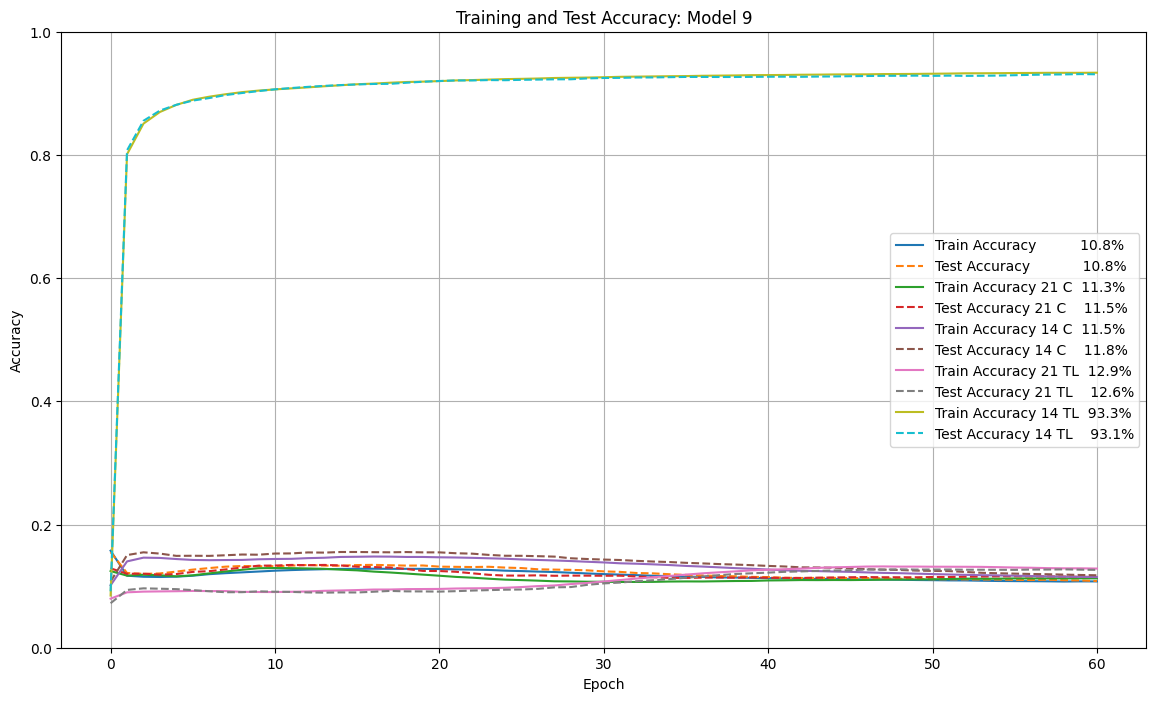

Epoch Final


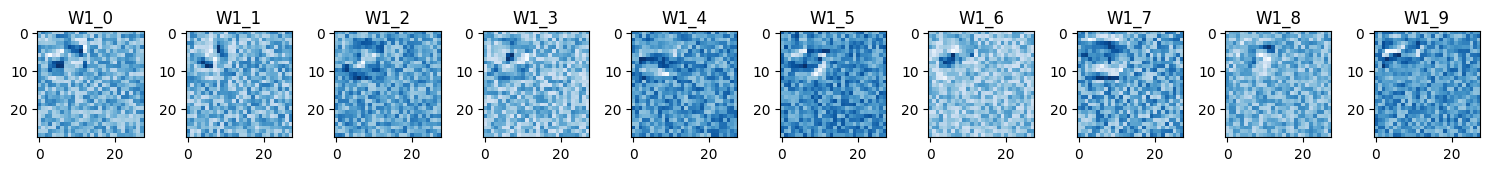

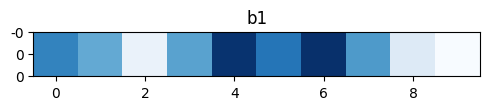

In [118]:
TestName = "Model 9"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_train_new_s_784_14_tl_t   # *************** Change here ******************

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

Make three datasets (original, 28c, and 21c) as one dataset

In [119]:
combined_Xtrain = np.concatenate((X_train_s_784_t, X_train_new_s_784_21_c_t, X_train_new_s_784_14_c_t), axis=1)
print(combined_Xtrain.shape)
combined_Ytrain = np.concatenate((Y_train, Y_train, Y_train))
print(combined_Ytrain.shape)
combined_Ytrain_reshaped = combined_Ytrain.reshape(1,180000)
print(combined_Ytrain_reshaped.shape)
combined_Ytrain_Xtrain = np.concatenate((combined_Ytrain_reshaped, combined_Xtrain), axis=0)
print(combined_Ytrain_Xtrain.shape)
print(combined_Ytrain_Xtrain)
np.random.shuffle(combined_Ytrain_Xtrain.T)    # make the data order random so train will not be distorted by a specific data set. 
print(combined_Ytrain_Xtrain)
Y_train_3c = combined_Ytrain_Xtrain[0, :]
print(Y_train_3c)
print(Y_train_3c.shape)
Y_train_3c = Y_train_3c.astype(np.int)
print(Y_train_3c)
X_train_3c = combined_Ytrain_Xtrain[1:, :]
print(X_train_3c)

(784, 180000)
(180000,)
(1, 180000)
(785, 180000)
[[5. 0. 4. ... 5. 6. 8.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 2. ... 5. 3. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 1. 2. ... 5. 3. 2.]
(180000,)
[1 1 2 ... 5 3 2]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(Model 10): (Model 1) + train data changed from original to original + 21c + 14c

- 90.2% c, 90.9% 21c, 88.8% 14c (Model 10) vs. 93.7% (Model 1) accuracy. Though the train data have multiple size of center datar, the accuracy maintains the same level as the orinal one.

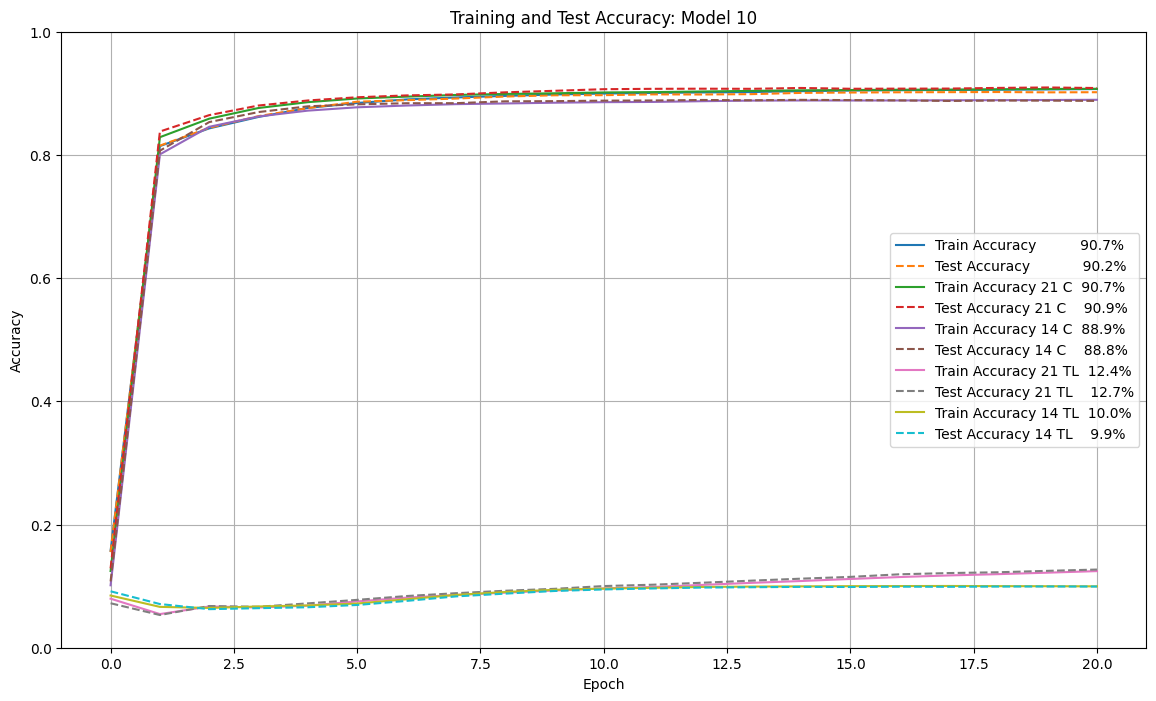

Epoch Final


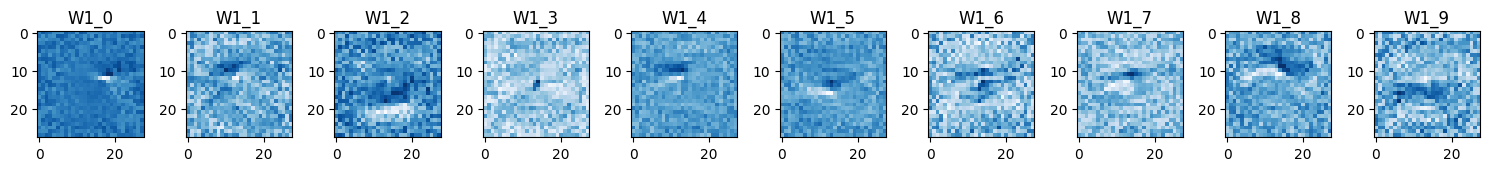

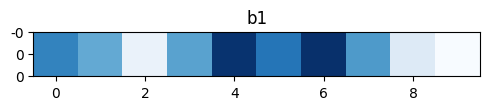

In [120]:
TestName = "Model 10"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_train_3c   # *************** Change here ******************
Y = Y_train_3c   # *************** Change here ******************
epoch = 20+1         # Total data is 3x so epoch should be 1/3 to see at the same training iteration condition
fp = final_point = (epoch-1)/record #Need to recalculate if epoch or record is changed.

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

In [121]:
#all 5 data train !!!
combined_Xtrain_5 = np.concatenate((X_train_s_784_t, X_train_new_s_784_21_c_t, X_train_new_s_784_14_c_t, X_train_new_s_784_21_tl_t, X_train_new_s_784_14_tl_t), axis=1)
print(combined_Xtrain_5.shape)
combined_Ytrain_5 = np.concatenate((Y_train, Y_train, Y_train, Y_train, Y_train))
print(combined_Ytrain_5.shape)
combined_Ytrain_reshaped_5 = combined_Ytrain_5.reshape(1,60000*5)
print(combined_Ytrain_reshaped_5.shape)
combined_Ytrain_Xtrain_5 = np.concatenate((combined_Ytrain_reshaped_5, combined_Xtrain_5), axis=0)
print(combined_Ytrain_Xtrain_5.shape)
print(combined_Ytrain_Xtrain_5)
np.random.shuffle(combined_Ytrain_Xtrain_5.T)
print(combined_Ytrain_Xtrain_5)
Y_train_5 = combined_Ytrain_Xtrain_5[0, :]
print(Y_train_5)
print(Y_train_5.shape)
Y_train_5 = Y_train_5.astype(np.int)
print(Y_train_5)
X_train_5 = combined_Ytrain_Xtrain_5[1:, :]
print(X_train_5)

(784, 300000)
(300000,)
(1, 300000)
(785, 300000)
[[5. 0. 4. ... 5. 6. 8.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[4. 5. 6. ... 9. 5. 3.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[4. 5. 6. ... 9. 5. 3.]
(300000,)
[4 5 6 ... 9 5 3]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(Model 11): (Model 1) + train data changed from original to original + 21c + 14c + 21tl +14tl

- 86.0% c, 86.6% 21c, 86.4% 14c, 83.4% 21tl, 86.2% 14tl  (Model 11) vs. 93.7% (Model 1) accuracy. Though the train data have multiple size of center datar, the accuracy maintains the same level as the orinal one. This is amazing with just 1 layer and 10 width can handle all of these types of data.
- Some W1 seem to be focused on a specific area (21c, 14c, 21tl, or 14tl). e.g W1_0 seems to be focused on the 14tl area.


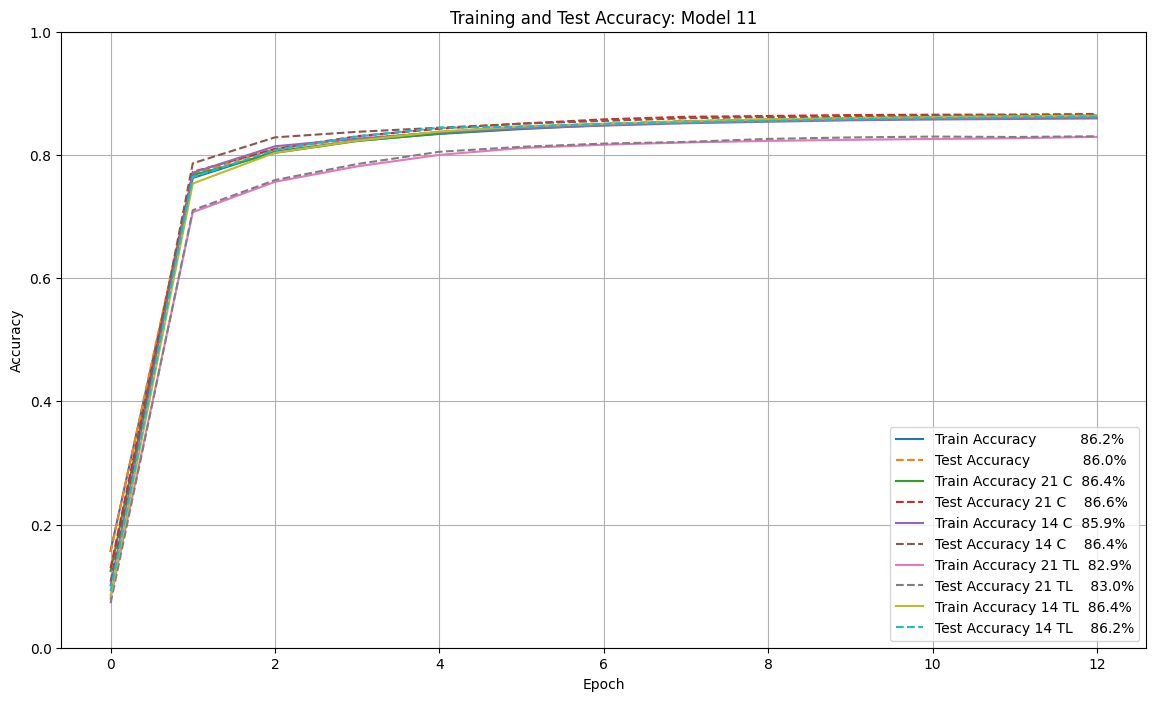

Epoch Final


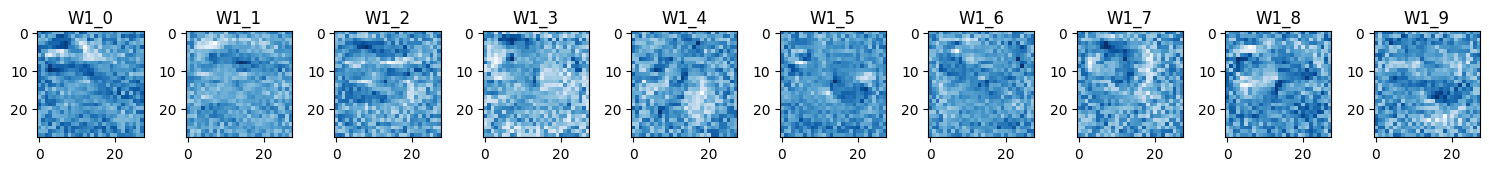

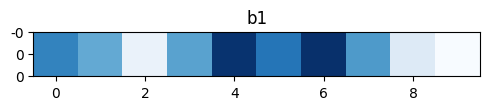

In [122]:
TestName = "Model 11"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_train_5   # *************** Change here ******************
Y = Y_train_5
epoch = 12+1         # Total data is 3x so epoch should be 1/3 to see at the same training iteration condition
fp = final_point = (epoch-1)/record #Need to recalculate if epoch or record is changed.

W1, b1, W2, b2, W3, b3 = init_params(Layer_1_Width, Layer_2_Width, Layer_3_Width)   # Set the initial parameters with random numbers.
results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

In [123]:
result_11tests = resultset_df.iloc[0:11, :]
result_11tests

,results_df
Model 1,Index X_train X_test X_train_21_c X_t...
Model 2,Index X_train X_test X_train_21_c X_t...
Model 3,Index X_train X_test X_train_21_c X_t...
Model 4,Index X_train X_test X_train_21_c X_t...
Model 5,Index X_train X_test X_train_21_c X_...
Model 6,Index X_train X_test X_train_21_c X_t...
Model 7,Index X_train X_test X_train_21_c X_t...
Model 8,Index X_train X_test X_train_21_c X_t...
Model 9,Index X_train X_test X_train_21_c X_t...
Model 10,Index X_train X_test X_train_21_c X_t...


In [125]:
result_01 = result_11tests.iloc[0,0]
result_01

,Index,X_train,X_test,X_train_21_c,X_test_21_c,X_train_14_c,X_test_14_c,X_train_21_tl,X_test_21_tl,X_train_14_tl,...,W3,b3,dW1,db1,dW2,db2,Z1,A1,Z2,A2
0,0,0.157483,0.1552,0.124500,0.1289,0.101367,0.1076,0.079633,0.0722,0.084750,...,0,0,0,0,0,0,0,0,0,0
1,1,0.822867,0.8276,0.437100,0.4328,0.172383,0.1736,0.042883,0.0400,0.071600,...,0,0,0,0,0,0,0,0,0,0
2,2,0.868883,0.8725,0.451900,0.4509,0.168733,0.1672,0.062583,0.0642,0.073050,...,0,0,0,0,0,0,0,0,0,0
3,3,0.883800,0.8883,0.458300,0.4596,0.172833,0.1719,0.066767,0.0676,0.073167,...,0,0,0,0,0,0,0,0,0,0
4,4,0.891733,0.8915,0.461467,0.4616,0.183333,0.1830,0.067283,0.0671,0.073383,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,56,0.946750,0.9374,0.535817,0.5255,0.243400,0.2452,0.152050,0.1538,0.065850,...,0,0,0,0,0,0,0,0,0,0
57,57,0.946983,0.9373,0.536017,0.5255,0.243383,0.2446,0.152550,0.1550,0.066000,...,0,0,0,0,0,0,0,0,0,0
58,58,0.947200,0.9373,0.536083,0.5258,0.243800,0.2448,0.152667,0.1552,0.066367,...,0,0,0,0,0,0,0,0,0,0
59,59,0.947533,0.9373,0.535883,0.5259,0.244217,0.2454,0.152683,0.1544,0.066750,...,0,0,0,0,0,0,0,0,0,0


In [126]:
for i in range(11):

    result_11tests.iloc[i,0].iloc[-1].loc["Index"] = result_11tests.index[i]
    
    print(result_11tests.iloc[i,0].iloc[-1][0:3])


Index            60
X_train    0.947433
X_test       0.9367
Name: 60, dtype: object
Index            60
X_train    0.971633
X_test       0.9592
Name: 60, dtype: object
Index            60
X_train    0.947433
X_test       0.9367
Name: 60, dtype: object
Index           60
X_train    0.87955
X_test      0.8775
Name: 60, dtype: object
Index           300
X_train    0.912067
X_test       0.9119
Name: 300, dtype: object
Index            60
X_train    0.569733
X_test       0.5771
Name: 60, dtype: object
Index           60
X_train    0.15905
X_test       0.157
Name: 60, dtype: object
Index           60
X_train    0.05545
X_test      0.0536
Name: 60, dtype: object
Index           60
X_train    0.10765
X_test      0.1082
Name: 60, dtype: object
Index            20
X_train    0.906933
X_test       0.9018
Name: 20, dtype: object
Index           12
X_train    0.86225
X_test      0.8598
Name: 12, dtype: object


In [127]:
result_11tests.iloc[0,0].iloc[-1]

Index                                                           60
X_train                                                   0.947433
X_test                                                      0.9367
X_train_21_c                                              0.536667
X_test_21_c                                                  0.526
X_train_14_c                                              0.244267
X_test_14_c                                                 0.2458
X_train_21_tl                                             0.153067
X_test_21_tl                                                0.1546
X_train_14_tl                                             0.066883
X_test_14_tl                                                0.0684
W1               [[-0.1254598811526375, 0.45071430640991617, 0....
b1               [[0.6944193696825581], [0.5656079990521835], [...
W2               [[0.7811713296995504, 0.6539032202257828, -0.3...
b2               [[0.4502112058654302], [-0.4367373281793252],

In [128]:
result_01_last = result_01.iloc[-1]
result_01_last

Index                                                           60
X_train                                                   0.947433
X_test                                                      0.9367
X_train_21_c                                              0.536667
X_test_21_c                                                  0.526
X_train_14_c                                              0.244267
X_test_14_c                                                 0.2458
X_train_21_tl                                             0.153067
X_test_21_tl                                                0.1546
X_train_14_tl                                             0.066883
X_test_14_tl                                                0.0684
W1               [[-0.1254598811526375, 0.45071430640991617, 0....
b1               [[0.6944193696825581], [0.5656079990521835], [...
W2               [[0.7811713296995504, 0.6539032202257828, -0.3...
b2               [[0.4502112058654302], [-0.4367373281793252],

In [129]:
result_01_last.loc["Index"] = result_11tests.index[0]
result_01_last[0:11]

Index             Model 1
X_train          0.947433
X_test             0.9367
X_train_21_c     0.536667
X_test_21_c         0.526
X_train_14_c     0.244267
X_test_14_c        0.2458
X_train_21_tl    0.153067
X_test_21_tl       0.1546
X_train_14_tl    0.066883
X_test_14_tl       0.0684
Name: 60, dtype: object

In [130]:
resultset_df.iloc[:, 0]

Model 1         Index   X_train  X_test  X_train_21_c  X_t...
Model 2         Index   X_train  X_test  X_train_21_c  X_t...
Model 3         Index   X_train  X_test  X_train_21_c  X_t...
Model 4         Index   X_train  X_test  X_train_21_c  X_t...
Model 5          Index   X_train  X_test  X_train_21_c  X_...
Model 6         Index   X_train  X_test  X_train_21_c  X_t...
Model 7         Index   X_train  X_test  X_train_21_c  X_t...
Model 8         Index   X_train  X_test  X_train_21_c  X_t...
Model 9         Index   X_train  X_test  X_train_21_c  X_t...
Model 10        Index   X_train  X_test  X_train_21_c  X_t...
Model 11        Index   X_train  X_test  X_train_21_c  X_t...
Name: results_df, dtype: object

(Model A1)

Here we will use the W1, b1, etc from the train result of (Model 1):original set.
Base on that basic model we created, we will apply new set of data, which is 21c, emulating that the "data change over time", in this case smaller.
In this case, we can get the correctr data from Y.

- Due to all the new data is from 21c, model is gradually more optimized for 21c and the accuracy for the original data set gets worse.

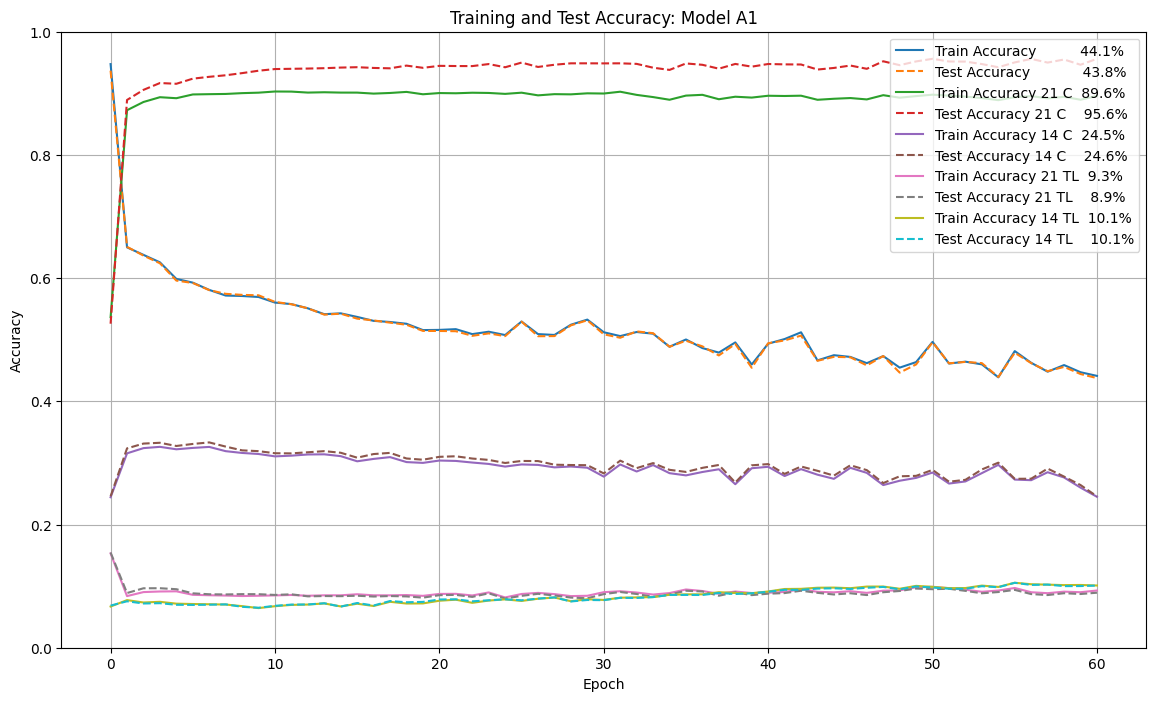

Epoch Final


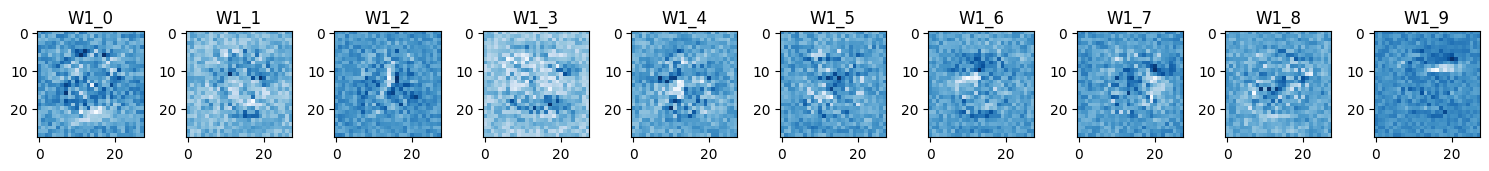

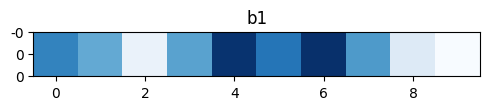

In [131]:
TestName = "Model A1"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_test_new_s_784_21_c_t
Y = Y_test          ##################### this Y is not actually used when predict_learn is 1.
batch = 10           # ********  2 x 5000
fp = final_point = (epoch-1)/record #Need to recalculate if epoch or record is changed.
alpha = 0.1
predict_learn = 0

# Use the Wx and bx previously defined at the end of the "Model 1" training.
result = resultset_df.loc["Model 1", "results_df"]
ep = fp
W1 = result.loc[ep,"W1"]
b1 = result.loc[ep,"b1"]
W2 = result.loc[ep,"W2"]
b2 = result.loc[ep,"b2"]
W3 = result.loc[ep,"W3"]            # Should be 0 due to 2 layers
b3 = result.loc[ep,"b3"]            # Should be 0 due to 2 layers

results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model A2): (Model A1) + Alpha from 0.1 to 0.001

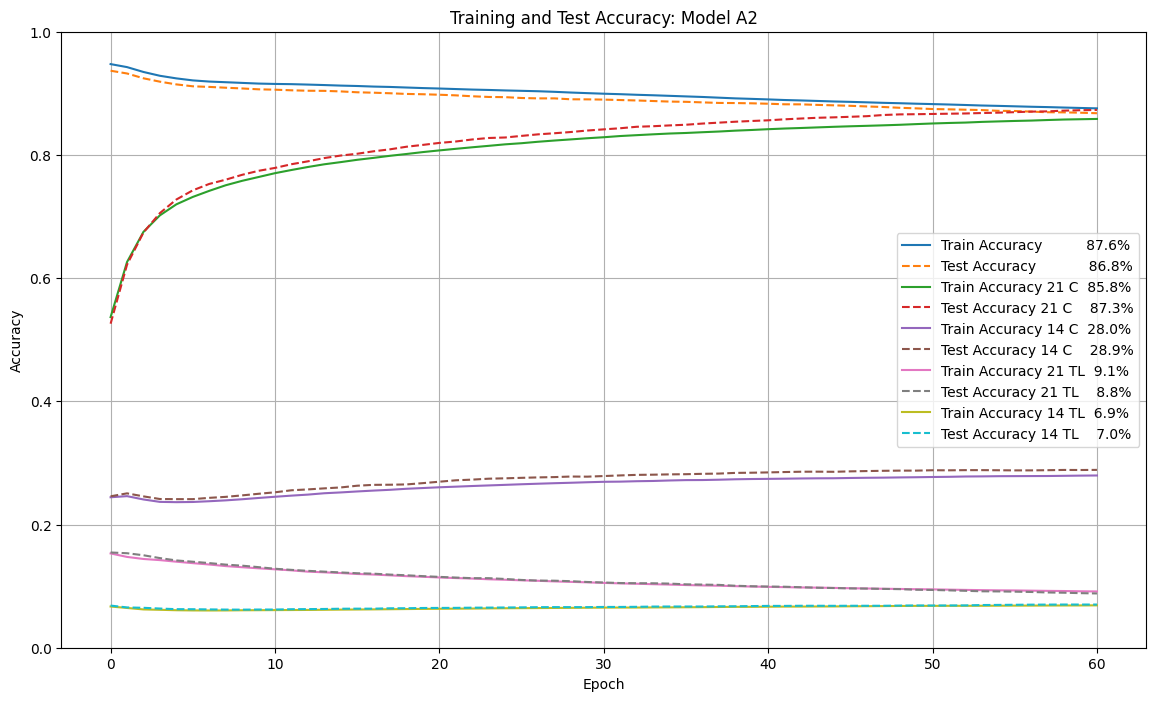

Epoch Final


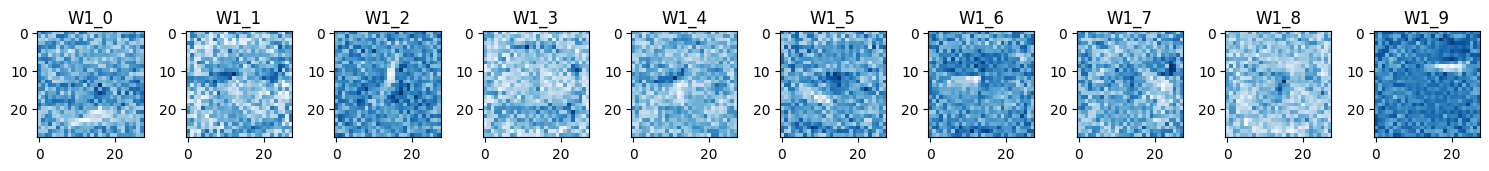

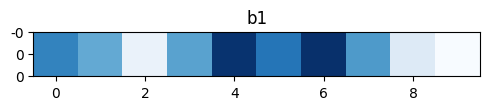

In [132]:
TestName = "Model A2"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_test_new_s_784_21_c_t
Y = Y_test          ##################### this Y is not actually used when predict_learn is 1.
batch = 10           # ********  2 x 5000
epoch = 60 + 1
fp = final_point = (epoch-1)/record #Need to recalculate if epoch or record is changed.
alpha = 0.0001      ##################### 0.0001 is appropriate at 60 epoch point.
predict_learn = 0

# Use the Wx and bx previously defined at the end of the "Model 1" training.
result = resultset_df.loc["Model 1", "results_df"]
ep = fp = 60
W1 = result.loc[ep,"W1"]
b1 = result.loc[ep,"b1"]
W2 = result.loc[ep,"W2"]
b2 = result.loc[ep,"b2"]
W3 = result.loc[ep,"W3"]            # Should be 0 due to 2 layers
b3 = result.loc[ep,"b3"]            # Should be 0 due to 2 layers

results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model B1): (Model A1) + predict_learn = 1

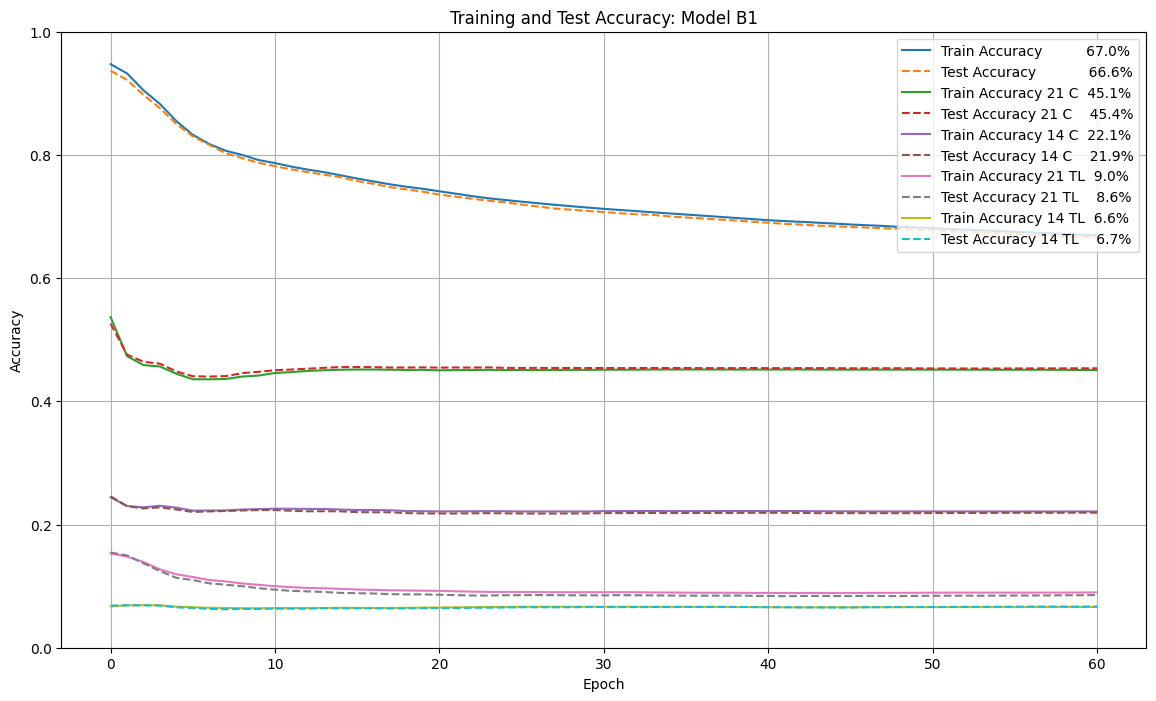

Epoch Final


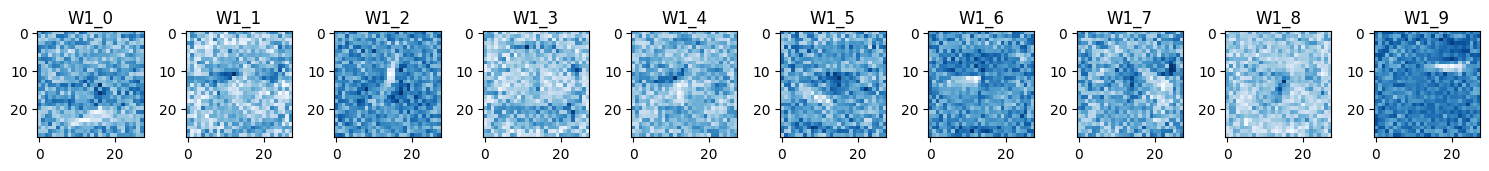

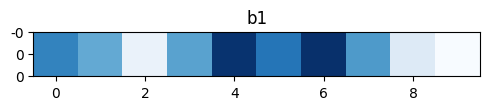

In [133]:
TestName = "Model B1"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_test_new_s_784_21_c_t
Y = Y_test          ##################### this Y is not actually used when predict_learn is 1.
batch = 10           # ********  2 x 5000
fp = final_point = (epoch-1)/record #Need to recalculate if epoch or record is changed.   fp here is   fp = 60 = (61 - 1) / 1
alpha = 0.001      ##################### 0.0001 is appropriate at 60 epoch point.
predict_learn = 1        # Self learning accumulation. No orrect feedback for each

# Use the Wx and bx previously defined at the end of the "Model 1" training.
result = resultset_df.loc["Model 1", "results_df"]
ep = 60                 # ep 
W1 = result.loc[ep,"W1"]
b1 = result.loc[ep,"b1"]
W2 = result.loc[ep,"W2"]
b2 = result.loc[ep,"b2"]
W3 = result.loc[ep,"W3"]            # Should be 0 due to 2 layers
b3 = result.loc[ep,"b3"]            # Should be 0 due to 2 layers

results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model B2): (Model B1) + data original

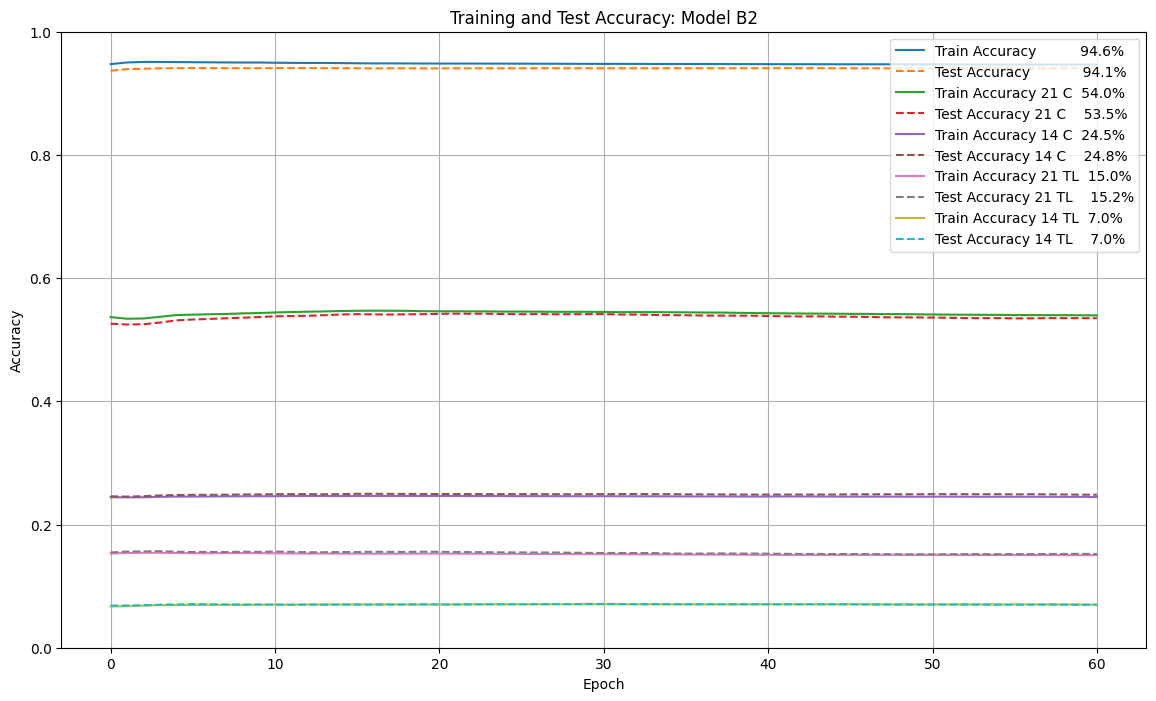

Epoch Final


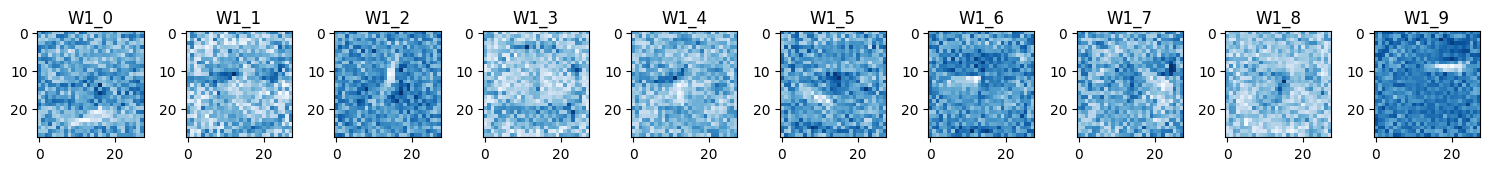

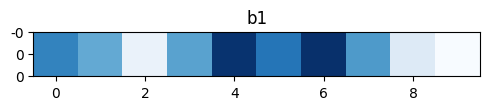

In [134]:
TestName = "Model B2"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_test_s_784_t
Y = Y_test          ##################### this Y is not actually used when predict_learn is 1.
batch = 10           # ********  2 x 5000
fp = final_point = (epoch-1)/record #Need to recalculate if epoch or record is changed.
predict_learn = 1
alpha = 0.001
# Use the Wx and bx previously defined at the end of the "Model 1" training.
result = resultset_df.loc["Model 1", "results_df"]
ep = fp = 60
W1 = result.loc[ep,"W1"]
b1 = result.loc[ep,"b1"]
W2 = result.loc[ep,"W2"]
b2 = result.loc[ep,"b2"]
W3 = result.loc[ep,"W3"]            # Should be 0 due to 2 layers
b3 = result.loc[ep,"b3"]            # Should be 0 due to 2 layers

results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model B3): (Model B1) + Model 10 base Wx and bx

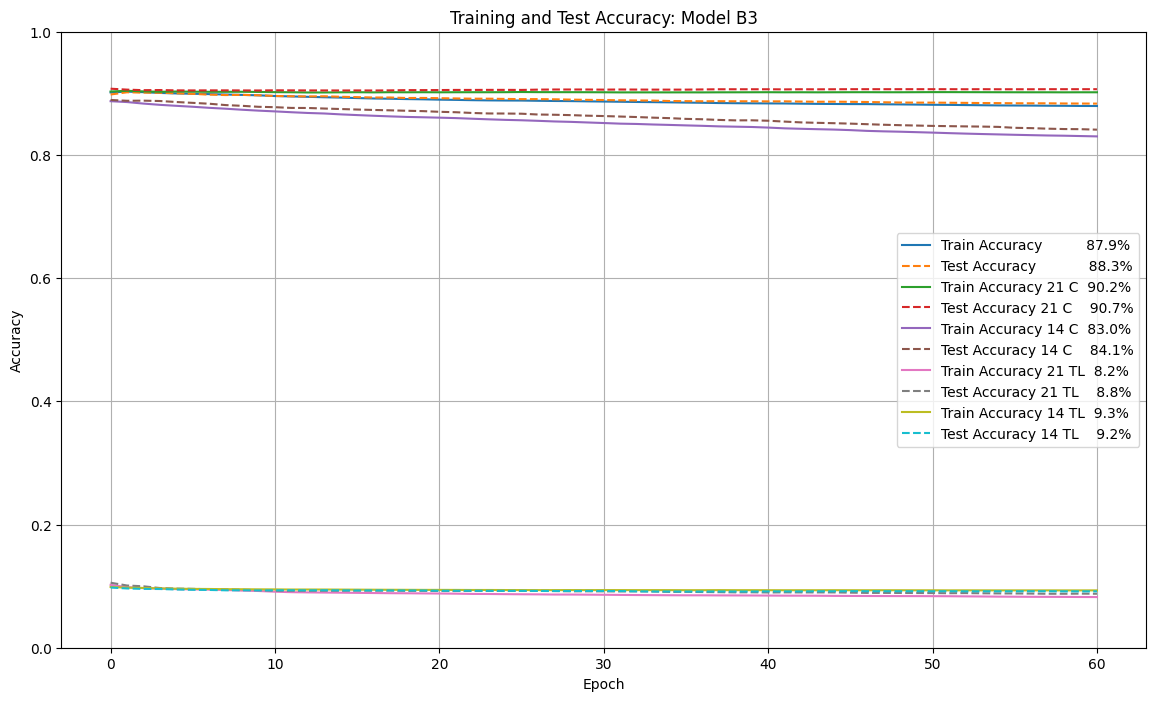

Epoch Final


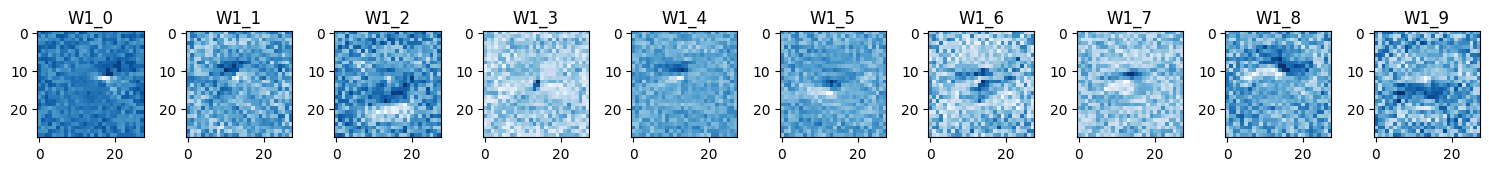

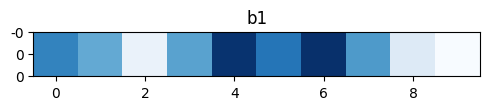

In [135]:
TestName = "Model B3"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X = X_test_new_s_784_21_c_t
Y = Y_test          ##################### this Y is not actually used when predict_learn is 1.
batch = 10           # ********  2 x 5000
fp = final_point = (epoch-1)/record #Need to recalculate if epoch or record is changed.
predict_learn = 1
alpha = 0.001
# Use the Wx and bx previously defined at the end of the "Model 10" training.
result = resultset_df.loc["Model 10", "results_df"]   ######################################  Change here
ep = fp = 12    ######################################  Change here
W1 = result.loc[ep,"W1"]
b1 = result.loc[ep,"b1"]
W2 = result.loc[ep,"W2"]
b2 = result.loc[ep,"b2"]
W3 = result.loc[ep,"W3"]            # Should be 0 due to 2 layers
b3 = result.loc[ep,"b3"]            # Should be 0 due to 2 layers

results_df, prediction_probabilities_df = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

(Model C1): (Model B1) + data original, 28c, 14c sequencial, self training by the highest accuracy of three data

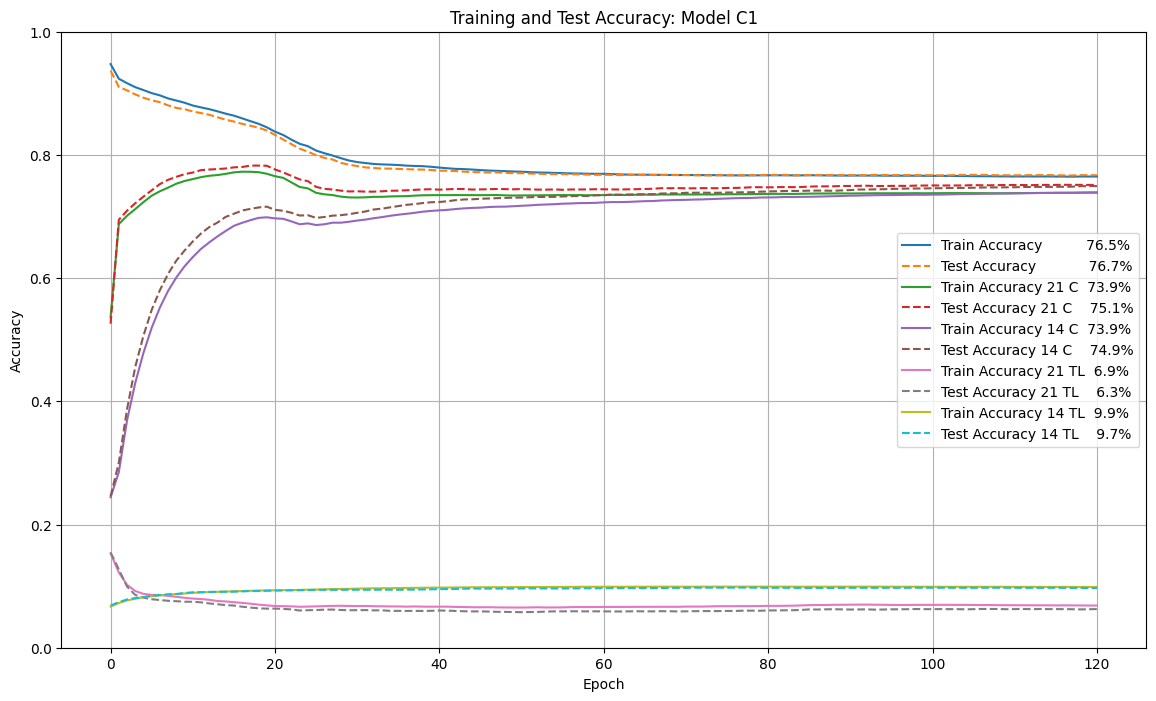

Epoch Final


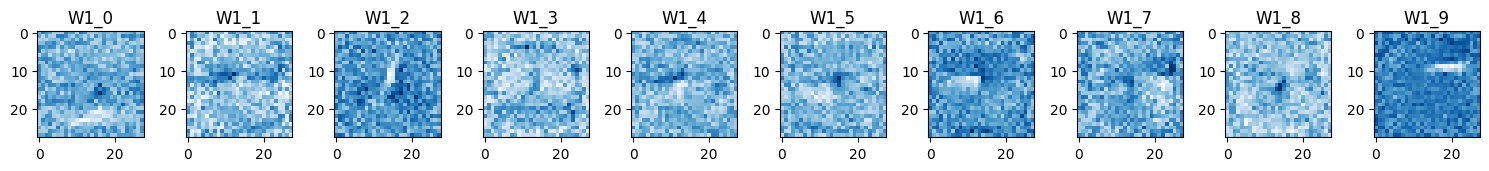

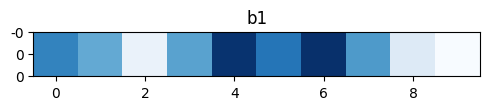

In [138]:
TestName = "Model C1"
X, Y, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, fp, a, b, c, graph_W1_only, predict_learn = default_settings()
X0 = X_test_s_784_t                      #10000 data
X1 = X_test_new_s_784_21_c_t             #10000 data
X2 = X_test_new_s_784_14_c_t             #10000 data
Y0 = Y                                   #10000 data We do not use these since we are predicting on the fly.
Y1 = Y                                   #10000 data We do not use these since we are predicting on the fly.
Y2 = Y                                   #10000 data We do not use these since we are predicting on the fly.

epoch = 120 + 1
batch = 3           #
fp = final_point = (epoch-1)/record #Need to recalculate if epoch or record is changed.
alpha = 0.0001      ##################### 0.0001 is appropriate at 60 epoch point.
predict_learn = 2        # Self learning accumulation. No orrect feedback for each

# Use the Wx and bx previously defined at the end of the "Model 1" training.
result = resultset_df.loc["Model 1", "results_df"]
ep = 60
W1 = result.loc[ep,"W1"]
b1 = result.loc[ep,"b1"]
W2 = result.loc[ep,"W2"]
b2 = result.loc[ep,"b2"]
W3 = result.loc[ep,"W3"]            # Should be 0 due to 2 layers
b3 = result.loc[ep,"b3"]            # Should be 0 due to 2 layers

X_columns = X0.shape[1] + X1.shape[1] + X2.shape[1]    # Data combine all three together   X0_0, X1_0, X2_0, X0_1, X1_1, X2_1, .....
interleaved_X = np.empty((X0.shape[0], X_columns), dtype=X0.dtype)   # X0.shape[0] is used just for the purpose of shape definition, [1], [2] are also fine.
interleaved_X[:, 0::3] = X0         # Incert X0_x values every 3 times
interleaved_X[:, 1::3] = X1         # Incert X0_x values every 3 times
interleaved_X[:, 2::3] = X2         # Incert X0_x values every 3 times
X = interleaved_X       # (784, 30000)

# Y below is filled with Y, but in reality it is not used since Yj generated on the fly will be used.
results_df, predictions_probabilities = gradient_descent(X, Y, W1, b1, W2, b2, W3, b3, layer, Layer_1_Width, Layer_2_Width, Layer_3_Width, batch, alpha, epoch, record, predict_learn)

new_row = pd.Series([results_df], index=columns)            # Save the result in new_row tentatively
resultset_df.loc[TestName] = new_row                        # Add the new result here to all the result stock "resultset_df" 
result = resultset_df.loc[TestName, "results_df"]           # Pick up this time result as "result".
graph(result, TestName)                                     # Dipaly the learning curve asscociated with accuracies.

# Show Wx, bx values based on the graph_W1_only setting.
# Last Epoch
graph_perceptron_l2("Epoch Final", result.loc[fp,"W1"], result.loc[fp,"b1"], result.loc[fp,"W2"], result.loc[fp,"b2"], 
                    result.loc[fp,"W3"], result.loc[fp,"b3"],Layer_1_Width, a, Layer_2_Width, b, Layer_3_Width, c, graph_W1_only)

Check the actual evolution of the prediction change (Epoch 0 and Epoch 120)

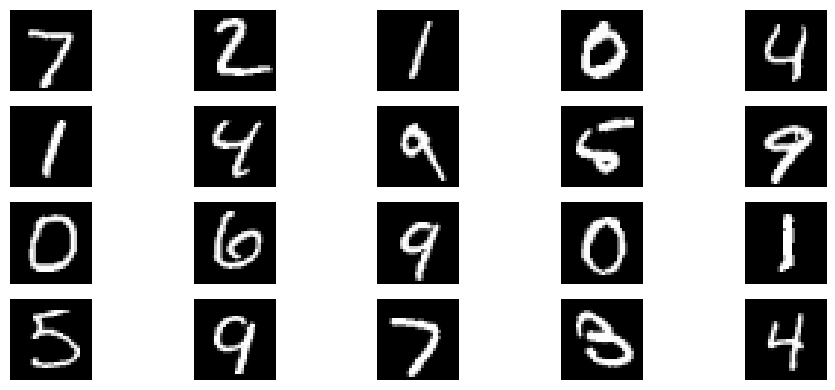

    epoch_i  split_j Predictions       Probabilities
0         0        0   [7, 7, 7]   [1.0, 0.99, 0.54]
1         0        1   [2, 2, 5]  [0.98, 0.68, 0.74]
2         0        2   [1, 1, 1]  [0.99, 0.82, 0.62]
3         0        3   [0, 0, 4]   [1.0, 0.36, 0.97]
4         0        4   [4, 4, 4]   [0.97, 1.0, 0.95]
5         0        5   [1, 1, 1]   [1.0, 0.98, 0.89]
6         0        6   [4, 4, 4]  [0.94, 0.96, 0.97]
7         0        7   [9, 5, 5]   [0.98, 0.76, 0.8]
8         0        8   [5, 5, 5]  [0.71, 0.98, 0.51]
9         0        9   [9, 4, 4]   [1.0, 0.95, 0.96]
10        0       10   [0, 0, 4]   [1.0, 0.45, 0.43]
11        0       11   [6, 2, 5]  [0.82, 0.72, 0.51]
12        0       12   [9, 4, 4]   [1.0, 0.47, 0.67]
13        0       13   [0, 9, 4]    [1.0, 0.5, 0.95]
14        0       14   [1, 1, 1]    [1.0, 1.0, 0.97]
15        0       15   [5, 7, 5]    [1.0, 0.5, 0.76]
16        0       16   [9, 4, 4]  [0.99, 0.91, 0.39]
17        0       17   [7, 7, 7]   [1.0, 0.97,

In [137]:
num = 20

fig, axes = plt.subplots(4, 5, figsize=(10, 4))  # 4 x 5 figures 

for i in range(num):
    ax = axes[i//5, i%5]  # Specify the current one
    current_image = interleaved_X[:, i*3].reshape(28, 28) * 255
    ax.imshow(current_image, cmap='gray', interpolation='nearest')
    ax.axis('off')  # no axis display

plt.tight_layout()  # Adjust figure margins
plt.show()

df = predictions_probabilities  #epoch is 60 for example
df["Probabilities"] = df["Probabilities"].apply(lambda x: [np.round(prob, 2) for prob in x])

print(df.head(num))
print(df.tail(num))
print(Y_test[0:num])
